
#**Setting up the initial environment and configurations**



In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import zipfile
from typing import List, Tuple, Optional
import os
from glob import glob

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve
)

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully")

# ==================== MOUNT GOOGLE DRIVE ====================
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# ==================== DIRECTORY CONFIGURATION ====================
BASE_DIR = "/content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation"
DATA_GLOB = str(Path(BASE_DIR) / "*.csv")  # Pattern to match CSV files
MODEL_BASE_DIR = os.path.join(BASE_DIR, "saved_models")

# Create model directory if it doesn't exist
os.makedirs(MODEL_BASE_DIR, exist_ok=True)

print(f"\n{'='*70}")
print("DIRECTORY CONFIGURATION")
print(f"{'='*70}")
print(f"Base Directory: {BASE_DIR}")
print(f"Data Pattern: {DATA_GLOB}")
print(f"Model Directory: {MODEL_BASE_DIR}")
print(f"{'='*70}\n")

All libraries imported successfully
Mounted at /content/drive

DIRECTORY CONFIGURATION
Base Directory: /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation
Data Pattern: /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation/*.csv
Model Directory: /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation/saved_models



#**Model Persistence Utility Functions**

In [ ]:
# ==================== MODEL PERSISTENCE UTILITIES ====================

import joblib

# MODEL_BASE_DIR already defined in Cell 1
print(f"Model storage directory: {MODEL_BASE_DIR}")

def save_model(model, model_name: str, model_type: str = "model"):
    """
    Save trained model or preprocessing object to file using joblib

    Args:
        model: Model or object to save (sklearn model, scaler, etc.)
        model_name: Name for the saved file
        model_type: Type description for logging (e.g., 'model', 'scaler', 'encoder')

    Returns:
        str: Filepath where model was saved
    """
    os.makedirs(MODEL_BASE_DIR, exist_ok=True)
    filepath = os.path.join(MODEL_BASE_DIR, f"{model_name}.joblib")

    try:
        joblib.dump(model, filepath)
        print(f"{model_type.title()} '{model_name}' saved to:")
        print(f"  {filepath}")
        return filepath
    except Exception as e:
        print(f"Error saving {model_type} '{model_name}': {e}")
        return None


def load_model(model_name: str, model_type: str = "model"):
    """
    Load trained model or preprocessing object from file using joblib

    Args:
        model_name: Name of the saved file (without .joblib extension)
        model_type: Type description for logging

    Returns:
        Loaded model/object or None if file doesn't exist
    """
    filepath = os.path.join(MODEL_BASE_DIR, f"{model_name}.joblib")

    if not os.path.exists(filepath):
        print(f" {model_type.title()} file '{model_name}.joblib' not found at:")
        print(f"  {filepath}")
        return None

    try:
        loaded_model = joblib.load(filepath)
        print(f" {model_type.title()} '{model_name}' loaded from:")
        print(f"  {filepath}")
        return loaded_model
    except Exception as e:
        print(f" Error loading {model_type} '{model_name}': {e}")
        return None


def list_saved_models():
    """List all saved models in the model directory"""
    if not os.path.exists(MODEL_BASE_DIR):
        print(f"Model directory does not exist: {MODEL_BASE_DIR}")
        return []

    model_files = [f for f in os.listdir(MODEL_BASE_DIR) if f.endswith('.joblib')]

    if not model_files:
        print("No saved models found")
        return []

    print(f"\n{'='*70}")
    print(f"SAVED MODELS in {MODEL_BASE_DIR}")
    print(f"{'='*70}")
    for i, filename in enumerate(sorted(model_files), 1):
        filepath = os.path.join(MODEL_BASE_DIR, filename)
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"{i}. {filename:40s} ({size_mb:.2f} MB)")
    print(f"{'='*70}\n")

    return model_files


# Test the utility functions
print("\n Model persistence utilities defined")
print("  - save_model(model, name)")
print("  - load_model(name)")
print("  - list_saved_models()")

# Check if any models already exist
if os.path.exists(MODEL_BASE_DIR):
    existing = [f for f in os.listdir(MODEL_BASE_DIR) if f.endswith('.joblib')]
    if existing:
        print(f"\n Found {len(existing)} existing model(s)")
        print("  Run list_saved_models() to see them")
    else:
        print("\n No existing models found (will be created during training)")
else:
    print("\n Model directory will be created when first model is saved")

Model storage directory: /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation/saved_models

 Model persistence utilities defined
  - save_model(model, name)
  - load_model(name)
  - list_saved_models()

 Found 7 existing model(s)
  Run list_saved_models() to see them


#**Configuration && Feature Definitions**



In [ ]:
# ==================== CONFIGURATION & FEATURE DEFINITIONS ====================
# This cell defines all the configuration for data loading, feature selection,
# and the CRITICAL duplicate removal configuration
# FOCUS: DoS/DDoS Attack Detection

print("="*70)
print("CONFIGURATION SETUP - DoS/DDoS Attacks Focussed ")
print("="*70)

# ------------------------ DATA LOADING SETTINGS ------------------------
print(f"\n Data Configuration:")
print(f"  Base Directory: {BASE_DIR}")
print(f"  Data Pattern: {DATA_GLOB}")

# Files we'll be processing (DoS/DDoS focused subset)
TARGET_FILES = [
    "02-15-2018.csv",  # ~1,048,575 rows - Contains DoS attacks
    "02-16-2018.csv",  # ~1,048,575 rows - Contains DoS attacks
    "02-21-2018.csv",  # ~1,048,575 rows - Contains DDoS attacks
    "03-01-2018.csv",  # ~331,125 rows - Contains DoS/DDoS attacks
]
TOTAL_EXPECTED_ROWS = 1048575 + 1048575 + 1048575 + 331125  # ~3,476,850 rows

print(f"\n   Target Files (DoS/DDoS focused subset):")
for i, file in enumerate(TARGET_FILES, 1):
    if "03-01" in file:
        print(f"    {i}. {file:25s} (~331,125 rows)")
    else:
        print(f"    {i}. {file:25s} (~1,048,575 rows)")
print(f"\n   Expected Total: ~{TOTAL_EXPECTED_ROWS:,} rows before preprocessing")
print(f"   Focus: DoS and DDoS attack detection using ML models")

# Rows to load per file (None = all rows, set to 100000 for testing)
MAX_ROWS_PER_FILE: int | None = None  # Change to 100000 for quick testing

if MAX_ROWS_PER_FILE:
    print(f"\n    Testing Mode: Loading {MAX_ROWS_PER_FILE:,} rows per file")
    print(f"  Expected Total (limited): ~{len(TARGET_FILES) * MAX_ROWS_PER_FILE:,} rows")
else:
    print(f"\n   Production Mode: Loading ALL rows from all 4 files")

# ------------------------ LABEL CONFIGURATION ------------------------
print(f"\n DoS/DDoS Attack Detection Configuration:")

ATTACK_KEYWORDS = [
    "DoS", "DDoS", "Hulk", "GoldenEye", "Slowloris", "HOIC", "LOIC", "LOIC-UDP"
]
LABEL_COL = "Label"

print(f"  Label Column: '{LABEL_COL}'")
print(f"  DoS/DDoS Attack Keywords ({len(ATTACK_KEYWORDS)}):")
for keyword in ATTACK_KEYWORDS:
    print(f"     {keyword}")

print(f"\n  Binary Classification:")
print(f"    Class 0: Benign (normal traffic)")
print(f"    Class 1: DoS/DDoS (attack traffic)")

# ------------------------ FEATURE CONFIGURATION ------------------------
print(f"\n Feature Configuration:")

# Primary features for DoS detection
CANDIDATE_FEATURES = [
    "Flow Duration", "Tot Fwd Pkts", "Tot Bwd Pkts",
    "TotLen Fwd Pkts", "TotLen Bwd Pkts",
    "Fwd Pkt Len Mean", "Bwd Pkt Len Mean",
    "Fwd Pkt Len Std", "Bwd Pkt Len Std",
    "Flow Byts/s", "Flow Pkts/s",
    "Fwd IAT Mean", "Bwd IAT Mean", "Flow IAT Mean",
    "Fwd IAT Std", "Bwd IAT Std",
    "Pkt Len Mean", "Pkt Len Std", "Pkt Len Var",
    "Down/Up Ratio", "Bwd Pkts/b Avg", "Fwd Pkts/b Avg",
    "Bwd Seg Size Avg", "Fwd Seg Size Avg",
    "Subflow Fwd Pkts", "Subflow Bwd Pkts",
    "Subflow Fwd Byts", "Subflow Bwd Byts",
    "Fwd Act Data Pkts",
    "Idle Mean", "Idle Std", "Idle Max", "Idle Min",
]

# Optional TCP flag features (important for DoS detection)
OPTIONAL_FEATURES = [
    "SYN Flag Cnt", "ACK Flag Cnt", "PSH Flag Cnt",
    "RST Flag Cnt", "URG Flag Cnt"
]

print(f"  Primary Features: {len(CANDIDATE_FEATURES)}")
print(f"  Optional Features: {len(OPTIONAL_FEATURES)} (TCP flags - useful for DoS)")
print(f"  Total Possible Features: {len(CANDIDATE_FEATURES) + len(OPTIONAL_FEATURES)}")

# ------------------------  DUPLICATE REMOVAL CONFIGURATION ------------------------
print(f"\n{'='*70}")
print("DUPLICATE REMOVAL CONFIGURATION")
print(f"{'='*70}")
print("These columns have UNIQUE/NEAR-UNIQUE values and MUST be EXCLUDED")
print("from duplicate detection, otherwise duplicate removal will FAIL!")
print("")

# Columns with unique or near-unique values - MUST EXCLUDE from duplicate detection
UNIQUE_VALUE_COLS = [
    "Flow ID",           # Unique identifier (always different)
    "Src IP",           # Source IP (many unique values)
    "Dst IP",           # Destination IP (many unique values)
    "Src Port",         # Source port (highly variable)
    "Dst Port",         # Destination port (variable)
    "Timestamp",        # Timestamp (unique/near-unique)
    "TimeStamp",        # Alternative spelling
    "Source IP",        # Alternative column name
    "Destination IP",   # Alternative column name
    "Source Port",      # Alternative column name
    "Destination Port", # Alternative column name
    "__source_file",    # Internal tracking column
]

print("Columns EXCLUDED from duplicate detection:")
for col in UNIQUE_VALUE_COLS:
    print(f"   {col}")

print(f"\nWhy exclude these?")
print(f"  If you include Flow ID, IPs, ports, or timestamps in duplicate detection,")
print(f"  every row appears 'unique' even if traffic patterns are identical!")
print(f"  This prevents proper duplicate removal.")
print(f"{'='*70}\n")

# ------------------------ FEATURE CATEGORIZATION ------------------------
# These are helpful for understanding your features

# LEAKY features: Should never be used as features (include identifiers and label)
LEAKY_COLS = [
    "Label", "y",                                    # Target variables
    "Timestamp", "TimeStamp", "__source_file",       # Temporal/metadata
    "Flow ID", "Src IP", "Dst IP", "Src Port",      # Identifiers
]

# RISKY features: Use with caution (may cause data leakage in some scenarios)
RISKY_COLS = ["Dst Port", "Protocol"]

# RATE features: May contain inf values, need special handling
RATE_COLS = ["Flow Byts/s", "Flow Pkts/s"]

print(f" Feature Categories (for reference):")
print(f"  Leaky columns (never use as features): {len(LEAKY_COLS)}")
print(f"  Risky columns (use with caution): {len(RISKY_COLS)}")
print(f"  Rate columns (may have inf values): {len(RATE_COLS)}")

# ------------------------ NON-FEATURE COLUMNS ------------------------
# Columns that should never be used as model features
NON_FEATURE_COLS = set(UNIQUE_VALUE_COLS + LEAKY_COLS)

print(f"\n Total NON-FEATURE columns: {len(NON_FEATURE_COLS)}")

# ------------------------ SUMMARY ------------------------
print(f"\n{'='*70}")
print("CONFIGURATION SUMMARY - DoS/DDoS DETECTION")
print(f"{'='*70}")
print(f" Dataset:")
print(f"  • Files: {len(TARGET_FILES)} CSV files")
print(f"  • Expected rows: ~{TOTAL_EXPECTED_ROWS:,}")
print(f"  • Mode: {'Testing (limited rows)' if MAX_ROWS_PER_FILE else 'Production (all rows)'}")
print(f"\n Task: Binary Classification (Benign vs DoS/DDoS)")
print(f"  • Attack types: {len(ATTACK_KEYWORDS)}")
print(f"\n Features:")
print(f"  • Primary: {len(CANDIDATE_FEATURES)}")
print(f"  • Optional: {len(OPTIONAL_FEATURES)}")
print(f"  • Total possible: {len(CANDIDATE_FEATURES) + len(OPTIONAL_FEATURES)}")
print(f"\n Preprocessing:")
print(f"  • Duplicate detection excludes: {len(UNIQUE_VALUE_COLS)} columns")
print(f"  • Non-feature columns: {len(NON_FEATURE_COLS)}")
print(f"{'='*70}\n")

print(" Configuration complete! Ready for data loading and preprocessing.")
print(" Next steps: Load CSVs → Remove duplicates → Create labels → Train model")

CONFIGURATION SETUP - DoS/DDoS Attacks Focussed 

 Data Configuration:
  Base Directory: /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation
  Data Pattern: /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation/*.csv

   Target Files (DoS/DDoS focused subset):
    1. 02-15-2018.csv            (~1,048,575 rows)
    2. 02-16-2018.csv            (~1,048,575 rows)
    3. 02-21-2018.csv            (~1,048,575 rows)
    4. 03-01-2018.csv            (~331,125 rows)

   Expected Total: ~3,476,850 rows before preprocessing
   Focus: DoS and DDoS attack detection using ML models

   Production Mode: Loading ALL rows from all 4 files

 DoS/DDoS Attack Detection Configuration:
  Label Column: 'Label'
  DoS/DDoS Attack Keywords (8):
     DoS
     DDoS
     Hulk
     GoldenEye
     Slowloris
     HOIC
     LOIC
     LOIC-UDP

  Binary Classification:
    Class 0: Benign (normal traffic)
    Class 1: DoS/DDoS (attack traffic)

 Feature Configuration:
  Primary Features: 33

## Load Data

In [ ]:
# ==================== DATA LOADING & LABELING FUNCTIONS ====================
# Functions to load CSV files and create binary labels for DoS/DDoS detection

print("="*70)
print("DATA LOADING & LABELING FUNCTIONS")
print("="*70)

def _read_csv(fpath: Path, max_rows: int | None) -> pd.DataFrame:
    """
    Read either .csv or .csv.zip into a DataFrame

    Args:
        fpath: Path to CSV file or ZIP file containing CSV
        max_rows: Maximum rows to read (None = all rows)

    Returns:
        DataFrame with loaded data
    """
    if str(fpath).endswith(".zip"):
        with zipfile.ZipFile(fpath, "r") as z:
            # Pick the first .csv inside the zip
            inner_csvs = [n for n in z.namelist() if n.lower().endswith(".csv")]
            if not inner_csvs:
                raise ValueError(f"No CSV found inside {fpath.name}")
            inner = inner_csvs[0]
            with z.open(inner) as fh:
                return pd.read_csv(fh, low_memory=False, nrows=max_rows)
    else:
        return pd.read_csv(fpath, low_memory=False, nrows=max_rows)


def load_cic_csvs(glob_pattern: str = DATA_GLOB,
                  max_rows_per_file: int | None = MAX_ROWS_PER_FILE,
                  target_files: List[str] = None) -> pd.DataFrame:
    """
    Load CIC-IDS-2018 CSV files from directory

    Args:
        glob_pattern: Glob pattern to match files
        max_rows_per_file: Maximum rows per file (None = all)
        target_files: Specific filenames to load (None = load all matching pattern)

    Returns:
        Combined DataFrame from all loaded files
    """
    # Get all matching files
    all_files = sorted(Path(glob_pattern).parent.glob(Path(glob_pattern).name))

    if not all_files:
        raise FileNotFoundError(f"No files matched pattern: {glob_pattern}")

    # Filter to target files if specified
    if target_files:
        files_to_load = [f for f in all_files if f.name in target_files]
        if not files_to_load:
            raise FileNotFoundError(
                f"None of the target files {target_files} found in {Path(glob_pattern).parent}"
            )
        print(f"\n Loading {len(files_to_load)} target files (DoS/DDoS focused):")
    else:
        files_to_load = all_files
        print(f"\n Loading all {len(files_to_load)} matching files:")

    # Load files
    dfs: List[pd.DataFrame] = []
    total_rows = 0

    for i, f in enumerate(files_to_load, 1):
        try:
            print(f"  [{i}/{len(files_to_load)}] Loading: {f.name:35s} ... ", end="")
            df = _read_csv(f, max_rows_per_file)
            df["__source_file"] = f.name
            dfs.append(df)
            total_rows += len(df)
            print(f"{len(df):,} rows")

        except Exception as e:
            print(f"Error: {e}")
            continue

    if not dfs:
        raise RuntimeError("No data could be loaded (all files failed).")

    # Combine all dataframes
    print(f"\n Combining data from {len(dfs)} file(s)...")
    combined_df = pd.concat(dfs, ignore_index=True)

    print(f"\n{'='*70}")
    print(f"DATA LOADING COMPLETE")
    print(f"{'='*70}")
    print(f" Files loaded: {len(dfs)}")
    print(f" Total rows: {len(combined_df):,}")
    print(f" Total columns: {len(combined_df.columns)}")
    print(f" Memory usage: {combined_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"{'='*70}\n")

    return combined_df


def label_binary_dos(df: pd.DataFrame,
                     label_col: str = LABEL_COL,
                     attack_keywords: List[str] = None,
                     verbose: bool = True) -> pd.DataFrame:
    """
    Create binary labels for DoS/DDoS detection and filter dataset

    Args:
        df: Input DataFrame
        label_col: Name of the label column
        attack_keywords: List of attack keywords (uses ATTACK_KEYWORDS if None)
        verbose: Print detailed statistics

    Returns:
        DataFrame with binary 'y' column (1=DoS/DDoS, 0=Benign)
        Only keeps Benign and DoS/DDoS rows (removes other attack types)
    """
    if attack_keywords is None:
        attack_keywords = ATTACK_KEYWORDS

    # Check if label column exists (handle case variations)
    if label_col not in df.columns:
        matches = [c for c in df.columns if c.lower() == label_col.lower()]
        if matches:
            df = df.rename(columns={matches[0]: label_col})
        else:
            raise KeyError(
                f"Column '{label_col}' not found. Available columns: {df.columns[:10].tolist()}..."
            )

    if verbose:
        print(f"\n{'='*70}")
        print("BINARY LABEL CREATION - DoS/DDoS vs Benign")
        print(f"{'='*70}")
        print(f"\n Original label distribution:")
        print(df[label_col].value_counts())

    # Convert labels to string for matching
    labels = df[label_col].astype(str).str.strip()

    # Identify DoS/DDoS attacks
    is_dos_attack = np.zeros(len(df), dtype=bool)
    for kw in attack_keywords:
        matches = labels.str.contains(kw, case=False, na=False)
        is_dos_attack |= matches
        if verbose:
            match_count = matches.sum()
            if match_count > 0:
                print(f"  • '{kw}': {match_count:,} samples")

    # Identify benign traffic
    is_benign = labels.str.contains("BENIGN", case=False, na=False)

    # Keep only Benign and DoS/DDoS samples (exclude other attack types)
    keep_mask = is_benign | is_dos_attack
    rows_before = len(df)
    df = df.loc[keep_mask].copy()
    rows_after = len(df)
    rows_removed = rows_before - rows_after

    if verbose:
        print(f"\n Filtering results:")
        print(f"   Rows before: {rows_before:,}")
        print(f"   Rows after: {rows_after:,}")
        print(f"   Removed (other attacks): {rows_removed:,} ({rows_removed/rows_before*100:.2f}%)")

    # Create binary label: 1 = DoS/DDoS attack, 0 = Benign
    # Make sure we only mark as attack if it's DoS/DDoS AND not benign
    df["y"] = (is_dos_attack[keep_mask] & ~is_benign[keep_mask]).astype(int)

    # Statistics
    benign_count = (df["y"] == 0).sum()
    attack_count = (df["y"] == 1).sum()

    if verbose:
        print(f"\n Binary label distribution:")
        print(f"   Class 0 (Benign): {benign_count:,} ({benign_count/len(df)*100:.2f}%)")
        print(f"   Class 1 (DoS/DDoS): {attack_count:,} ({attack_count/len(df)*100:.2f}%)")

        if attack_count > 0:
            imbalance_ratio = benign_count / attack_count
            print(f"\n  Class imbalance ratio: 1:{imbalance_ratio:.2f}")

            if imbalance_ratio > 10:
                print(f"    High imbalance detected! Consider using:")
                print(f"     • SMOTE for oversampling")
                print(f"     • class_weight='balanced' in models")
                print(f"     • Stratified sampling")

        print(f"{'='*70}\n")

    return df


# Test the functions are defined
print("\n Functions defined:")
print("   _read_csv(fpath, max_rows)")
print("   load_cic_csvs(glob_pattern, max_rows_per_file, target_files)")
print("   label_binary_dos(df, label_col, attack_keywords, verbose)")
print("\n Ready to load data!")

DATA LOADING & LABELING FUNCTIONS

 Functions defined:
   _read_csv(fpath, max_rows)
   load_cic_csvs(glob_pattern, max_rows_per_file, target_files)
   label_binary_dos(df, label_col, attack_keywords, verbose)

 Ready to load data!


## Load cleaned Data




In [ ]:
# ==================== LOAD DATA (DoS/DDoS FOCUSED FILES) ====================

print("="*70)
print("STEP 1: LOADING DATA")
print("="*70)

# Load ONLY the 4 target files for DoS/DDoS detection
df_raw = load_cic_csvs(
    glob_pattern=DATA_GLOB,
    max_rows_per_file=MAX_ROWS_PER_FILE,
    target_files=TARGET_FILES  # ← Uses your specific 4 files!
)

# Quick data exploration
print("\n Initial Data Exploration:")
print(f"  Shape: {df_raw.shape}")
print(f"  Columns: {len(df_raw.columns)}")
print(f"  Memory: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\n Column names (first 20):")
for i, col in enumerate(df_raw.columns[:20], 1):
    print(f"  {i:2d}. {col}")
if len(df_raw.columns) > 20:
    print(f"  ... and {len(df_raw.columns) - 20} more columns")

print(f"\n Sample data (first 3 rows):")
display(df_raw.head(3))

print(f"\n Label column check:")
if LABEL_COL in df_raw.columns:
    print(f"  '{LABEL_COL}' column found")
    print(f"\n  Label distribution (top 10):")
    print(df_raw[LABEL_COL].value_counts().head(10))
else:
    print(f"   '{LABEL_COL}' column not found!")
    print(f"  Available columns: {df_raw.columns.tolist()}")

print(f"\n Data loading complete! Ready for preprocessing.")

STEP 1: LOADING DATA

 Loading 4 target files (DoS/DDoS focused):
  [1/4] Loading: 02-15-2018.csv                      ... 1,048,575 rows
  [2/4] Loading: 02-16-2018.csv                      ... 1,048,575 rows
  [3/4] Loading: 02-21-2018.csv                      ... 1,048,575 rows
  [4/4] Loading: 03-01-2018.csv                      ... 331,125 rows

 Combining data from 4 file(s)...

DATA LOADING COMPLETE
 Files loaded: 4
 Total rows: 3,476,850
 Total columns: 81
 Memory usage: 11359.89 MB


 Initial Data Exploration:
  Shape: (3476850, 81)
  Columns: 81
  Memory: 11359.89 MB

 Column names (first 20):
   1. Dst Port
   2. Protocol
   3. Timestamp
   4. Flow Duration
   5. Tot Fwd Pkts
   6. Tot Bwd Pkts
   7. TotLen Fwd Pkts
   8. TotLen Bwd Pkts
   9. Fwd Pkt Len Max
  10. Fwd Pkt Len Min
  11. Fwd Pkt Len Mean
  12. Fwd Pkt Len Std
  13. Bwd Pkt Len Max
  14. Bwd Pkt Len Min
  15. Bwd Pkt Len Mean
  16. Bwd Pkt Len Std
  17. Flow Byts/s
  18. Flow Pkts/s
  19. Flow IAT Mean
  20. F

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,__source_file
0,0,0,15/02/2018 08:25:18,112641158,3,0,0,0,0,0,...,0.0,0.0,0,0,56320579.0,704.278354,56321077,56320081,Benign,02-15-2018.csv
1,22,6,15/02/2018 08:29:05,37366762,14,12,2168,2993,712,0,...,1024353.0,649038.754495,1601183,321569,11431221.0,3644990.559845,15617415,8960247,Benign,02-15-2018.csv
2,47514,6,15/02/2018 08:29:42,543,2,0,64,0,64,0,...,0.0,0.0,0,0,0.0,0.0,0,0,Benign,02-15-2018.csv



 Label column check:
  'Label' column found

  Label distribution (top 10):
Label
Benign                      2041719
DDOS attack-HOIC             686012
DoS attacks-Hulk             461912
DoS attacks-SlowHTTPTest     139890
Infilteration                 93063
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
DDOS attack-LOIC-UDP           1730
Label                            26
Name: count, dtype: int64

 Data loading complete! Ready for preprocessing.


In [ ]:
# ==================== DUPLICATE REMOVAL (CRITICAL FIX!) ====================

print("="*70)
print("STEP 2: REMOVE DUPLICATES (PROPERLY!)")
print("="*70)

def remove_duplicates_correctly(df: pd.DataFrame,
                                label_col: str = LABEL_COL,
                                verbose: bool = True) -> pd.DataFrame:
    """
    Remove duplicates by EXCLUDING columns with unique values

    This is the FIX for your duplicate removal issue!

    Args:
        df: Input DataFrame
        label_col: Label column name
        verbose: Print detailed statistics

    Returns:
        DataFrame with duplicates removed
    """
    initial_rows = len(df)

    # Get columns for duplicate detection (EXCLUDE unique-value columns)
    cols_for_dup_check = [
        col for col in df.columns
        if col not in UNIQUE_VALUE_COLS and col != label_col
    ]

    if verbose:
        print(f"\nDuplicate Detection Configuration:")
        print(f"  Total columns in dataset: {len(df.columns)}")
        print(f"  Columns used for duplicate check: {len(cols_for_dup_check)}")

        present_unique = [c for c in UNIQUE_VALUE_COLS if c in df.columns]
        print(f"  Columns EXCLUDED from duplicate check: {len(present_unique)}")
        print(f"    Excluded columns: {present_unique}")

        # Compare both methods to show the difference
        print(f"\n Duplicate Analysis (Before vs After Fix):")
        dup_wrong = df.duplicated().sum()
        dup_correct = df.duplicated(subset=cols_for_dup_check).sum()

        print(f"   Wrong method (includes ALL columns): {dup_wrong:,} duplicates found")
        print(f"   Correct method (features only): {dup_correct:,} duplicates found")
        print(f"   Difference: {dup_correct - dup_wrong:,} duplicates")
        print(f"     These are the duplicates you were MISSING!")

    # Remove duplicates using ONLY feature columns
    print(f"\n  Removing duplicates...")
    df_clean = df.drop_duplicates(subset=cols_for_dup_check, keep='first')

    final_rows = len(df_clean)
    removed = initial_rows - final_rows

    if verbose:
        print(f"\n Duplicate Removal Results:")
        print(f"  Before: {initial_rows:,} rows")
        print(f"  After:  {final_rows:,} rows")
        print(f"  Removed: {removed:,} rows ({removed/initial_rows*100:.2f}%)")

    print(f"\n{'='*70}")
    print(f" DUPLICATE REMOVAL COMPLETE")
    print(f"{'='*70}\n")

    return df_clean


# Apply duplicate removal to raw data
df_dedup = remove_duplicates_correctly(df_raw, LABEL_COL, verbose=True)

print(f" Clean dataset ready for labeling!")
print(f"   Shape: {df_dedup.shape}")

STEP 2: REMOVE DUPLICATES (PROPERLY!)

Duplicate Detection Configuration:
  Total columns in dataset: 81
  Columns used for duplicate check: 77
  Columns EXCLUDED from duplicate check: 3
    Excluded columns: ['Dst Port', 'Timestamp', '__source_file']

 Duplicate Analysis (Before vs After Fix):
   Wrong method (includes ALL columns): 167,661 duplicates found
   Correct method (features only): 1,287,235 duplicates found
   Difference: 1,119,574 duplicates
     These are the duplicates you were MISSING!

  Removing duplicates...

 Duplicate Removal Results:
  Before: 3,476,850 rows
  After:  2,189,615 rows
  Removed: 1,287,235 rows (37.02%)

 DUPLICATE REMOVAL COMPLETE

 Clean dataset ready for labeling!
   Shape: (2189615, 81)


In [ ]:
# ==================== CREATE BINARY LABELS (DoS/DDoS vs Benign) ====================

print("="*70)
print("STEP 3: CREATE BINARY LABELS FOR DoS/DDoS DETECTION")
print("="*70)

# Apply binary labeling function (already defined in Cell 4)
# This will:
#   1. Find all DoS/DDoS attacks using ATTACK_KEYWORDS
#   2. Keep only Benign and DoS/DDoS samples
#   3. Remove other attack types (not our focus)
#   4. Create 'y' column: 0=Benign, 1=DoS/DDoS

df_labeled = label_binary_dos(
    df=df_dedup,
    label_col=LABEL_COL,
    attack_keywords=ATTACK_KEYWORDS,
    verbose=True
)

# Quick verification
print(f" Final Dataset Summary:")
print(f"  Total samples: {len(df_labeled):,}")
print(f"  Features (columns): {len(df_labeled.columns)}")
print(f"  Benign samples: {(df_labeled['y']==0).sum():,}")
print(f"  DoS/DDoS samples: {(df_labeled['y']==1).sum():,}")

# Check class balance
benign_pct = (df_labeled['y']==0).sum() / len(df_labeled) * 100
attack_pct = (df_labeled['y']==1).sum() / len(df_labeled) * 100

print(f"\n Class Distribution:")
print(f"  Benign:   {benign_pct:.2f}%")
print(f"  DoS/DDoS: {attack_pct:.2f}%")

# Calculate imbalance ratio
if (df_labeled['y']==1).sum() > 0:
    imbalance = (df_labeled['y']==0).sum() / (df_labeled['y']==1).sum()
    print(f"\n  Imbalance Ratio: 1:{imbalance:.2f}")

    if imbalance > 10:
        print(f"    High imbalance! Recommendations:")
        print(f"      Use class_weight='balanced' in models")
        print(f"      Consider SMOTE oversampling")
        print(f"      Use stratified sampling in train/test split")
    elif imbalance > 3:
        print(f"    Moderate imbalance - use class_weight='balanced'")
    else:
        print(f"   Good balance!")

# Show sample of each class
print(f"\n Sample Data:")
print(f"\nBenign sample (y=0):")
display(df_labeled[df_labeled['y']==0][['Label', 'y'] + CANDIDATE_FEATURES[:5]].head(2))

print(f"\nDoS/DDoS sample (y=1):")
display(df_labeled[df_labeled['y']==1][['Label', 'y'] + CANDIDATE_FEATURES[:5]].head(2))

print(f"\n{'='*70}")
print(f" BINARY LABELING COMPLETE")
print(f"{'='*70}")
print(f"Ready for feature preparation!")
print(f"{'='*70}\n")

# Update df for next cell
df = df_labeled

STEP 3: CREATE BINARY LABELS FOR DoS/DDoS DETECTION

BINARY LABEL CREATION - DoS/DDoS vs Benign

 Original label distribution:
Label
Benign                      1736807
DDOS attack-HOIC             198861
DoS attacks-Hulk             145199
Infilteration                 55649
DoS attacks-GoldenEye         41406
DoS attacks-Slowloris          9907
DDOS attack-LOIC-UDP           1730
DoS attacks-SlowHTTPTest         55
Label                             1
Name: count, dtype: int64
  • 'DoS': 397,158 samples
  • 'DDoS': 200,591 samples
  • 'Hulk': 145,199 samples
  • 'GoldenEye': 41,406 samples
  • 'Slowloris': 9,907 samples
  • 'HOIC': 198,861 samples
  • 'LOIC': 1,730 samples
  • 'LOIC-UDP': 1,730 samples

 Filtering results:
   Rows before: 2,189,615
   Rows after: 2,133,965
   Removed (other attacks): 55,650 (2.54%)

 Binary label distribution:
   Class 0 (Benign): 1,736,807 (81.39%)
   Class 1 (DoS/DDoS): 397,158 (18.61%)

  Class imbalance ratio: 1:4.37

 Final Dataset Summary:
  Tot

,Label,y,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts
0,Benign,0,112641158,3,0,0,0
1,Benign,0,37366762,14,12,2168,2993



DoS/DDoS sample (y=1):


,Label,y,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts
44,DoS attacks-GoldenEye,1,6010454,4,4,285,972
45,DoS attacks-GoldenEye,1,6005042,4,4,422,662



 BINARY LABELING COMPLETE
Ready for feature preparation!



In [ ]:
# ==================== FEATURE PREPARATION & CLEANING ====================

print("="*70)
print("STEP 4: FEATURE PREPARATION & CLEANING")
print("="*70)

# Identify available features from our configuration
available_features = [f for f in CANDIDATE_FEATURES if f in df.columns]
optional_available = [f for f in OPTIONAL_FEATURES if f in df.columns]
all_features = available_features + optional_available

print(f"\n Feature Availability Check:")
print(f"  Primary features requested: {len(CANDIDATE_FEATURES)}")
print(f"  Primary features available: {len(available_features)}")
print(f"  Optional features available: {len(optional_available)}")
print(f"  Total features for modeling: {len(all_features)}")

# Show missing features if any
missing_primary = [f for f in CANDIDATE_FEATURES if f not in df.columns]
if missing_primary:
    print(f"\n    Missing primary features ({len(missing_primary)}):")
    for feat in missing_primary[:5]:
        print(f"    • {feat}")
    if len(missing_primary) > 5:
        print(f"    • ... and {len(missing_primary)-5} more")

# Select columns to keep: features + label + original label for reference
keep_cols = all_features + ['y', 'Label']

# Keep Timestamp if it exists (we'll drop it later)
if 'Timestamp' in df.columns:
    keep_cols.append('Timestamp')

print(f"\n Selecting {len(keep_cols)} columns...")
df_features = df[keep_cols].copy()

print(f"\n Cleaning data...")

# STEP 1: Convert ALL features to numeric FIRST (before any other operations)
print(f"\n  Step 1: Converting all features to numeric types...")
conversion_issues = []
for col in all_features:
    if col in df_features.columns:
        original_dtype = df_features[col].dtype
        if original_dtype == 'object' or original_dtype == 'string':
            # Convert to numeric, coercing errors to NaN
            df_features[col] = pd.to_numeric(df_features[col], errors='coerce')
            non_numeric_count = df_features[col].isna().sum()
            if non_numeric_count > 0:
                conversion_issues.append((col, non_numeric_count))
                print(f"    Converted '{col}' from {original_dtype} to numeric ({non_numeric_count:,} NaN from coercion)")

if not conversion_issues:
    print(f"     All features already numeric")
else:
    print(f"     Converted {len(conversion_issues)} columns to numeric")

# STEP 2: Replace infinite values with NaN
print(f"\n  Step 2: Replacing infinite values...")
rate_cols = ["Flow Byts/s", "Flow Pkts/s"]
inf_found = False

# Check rate columns specifically
for col in rate_cols:
    if col in df_features.columns:
        inf_count = df_features[col].isin([np.inf, -np.inf]).sum()
        if inf_count > 0:
            print(f"    '{col}': {inf_count:,} inf values found")
            df_features[col] = df_features[col].replace([np.inf, -np.inf], np.nan)
            inf_found = True

# Check all features for any remaining inf values
total_inf = df_features[all_features].isin([np.inf, -np.inf]).sum().sum()
if total_inf > 0:
    print(f"     Replacing {total_inf:,} total inf values across all features")
    df_features[all_features] = df_features[all_features].replace([np.inf, -np.inf], np.nan)
    inf_found = True

if not inf_found:
    print(f"     No infinite values found")

# STEP 3: Handle NaN values (fill with 0)
print(f"\n  Step 3: Handling NaN values...")
nan_count = df_features[all_features].isna().sum().sum()
if nan_count > 0:
    print(f"     Found {nan_count:,} NaN values")
    print(f"     Filling with 0")
    df_features[all_features] = df_features[all_features].fillna(0)
else:
    print(f"     No NaN values found")

# STEP 4: Final verification - no inf or NaN should remain
print(f"\n  Step 4: Final data quality verification...")
final_nan = df_features[all_features].isna().sum().sum()
final_inf = df_features[all_features].isin([np.inf, -np.inf]).sum().sum()

if final_nan > 0 or final_inf > 0:
    print(f"       Still have {final_nan} NaN and {final_inf} inf values!")
    print(f"    Performing emergency cleanup...")
    df_features[all_features] = df_features[all_features].replace([np.inf, -np.inf], 0).fillna(0)
    print(f"    Emergency cleanup complete")
else:
    print(f"    All clean - no NaN or inf values")

# STEP 5: Drop Timestamp column (not needed for modeling)
if 'Timestamp' in df_features.columns:
    df_features = df_features.drop(columns=['Timestamp'])
    print(f"\n Dropped 'Timestamp' column (not needed for ML)")

# STEP 6: Verify data quality
print(f"\n Data Quality Checks:")
print(f"   Final shape: {df_features.shape}")
print(f"   Feature columns: {len(all_features)}")
print(f"   NaN values: {df_features[all_features].isna().sum().sum()}")
print(f"   Inf values: {df_features[all_features].isin([np.inf, -np.inf]).sum().sum()}")
all_numeric = all([df_features[col].dtype in ['int64', 'float64', 'int32', 'float32'] for col in all_features])
print(f"   All numeric: {all_numeric}")

# STEP 7: Show feature statistics
print(f"\n Feature Statistics (first 5 features):")
display(df_features[all_features[:5]].describe())

print(f"\n{'='*70}")
print(f" FEATURE PREPARATION COMPLETE")
print(f"{'='*70}")
print(f" Clean dataset: {df_features.shape}")
print(f" Features: {len(all_features)}")
print(f" Benign: {(df_features['y']==0).sum():,} ({(df_features['y']==0).sum()/len(df_features)*100:.2f}%) Jardian )")
print(f" DoS/DDoS: {(df_features['y']==1).sum():,} ({(df_features['y']==1).sum()/len(df_features)*100:.2f}%) Jardian )")
print(f" Ready for train/test split!")
print(f"{'='*70}\n")

# Update df for next cell
df = df_features

# Store feature list for later use
FINAL_FEATURES = all_features
print(f" Stored {len(FINAL_FEATURES)} features in FINAL_FEATURES variable")

STEP 4: FEATURE PREPARATION & CLEANING

 Feature Availability Check:
  Primary features requested: 33
  Primary features available: 33
  Optional features available: 5
  Total features for modeling: 38

 Selecting 41 columns...

 Cleaning data...

  Step 1: Converting all features to numeric types...
    Converted 'Flow Byts/s' from object to numeric (689 NaN from coercion)
     Converted 1 columns to numeric

  Step 2: Replacing infinite values...
    'Flow Byts/s': 277 inf values found
    'Flow Pkts/s': 966 inf values found

  Step 3: Handling NaN values...
     Found 1,932 NaN values
     Filling with 0

  Step 4: Final data quality verification...
    All clean - no NaN or inf values

 Dropped 'Timestamp' column (not needed for ML)

 Data Quality Checks:
   Final shape: (2133965, 40)
   Feature columns: 38
   NaN values: 0
   Inf values: 0
   All numeric: True

 Feature Statistics (first 5 features):


,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts
count,2.133965e+06,2.133965e+06,2.133965e+06,2.133965e+06,2.133965e+06
mean,1.010996e+07,1.004305e+02,5.143420e+00,3.678009e+03,3.060619e+03
std,2.752342e+07,3.435627e+03,9.140161e+01,1.117637e+05,1.294150e+05
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.474000e+03,2.000000e+00,1.000000e+00,4.300000e+01,9.700000e+01
50%,6.361700e+04,5.000000e+00,2.000000e+00,4.550000e+02,3.140000e+02
75%,4.303025e+06,5.000000e+00,4.000000e+00,9.350000e+02,5.820000e+02
max,1.200000e+08,3.096290e+05,3.554700e+04,9.908128e+06,4.190000e+07



 FEATURE PREPARATION COMPLETE
 Clean dataset: (2133965, 40)
 Features: 38
 Benign: 1,736,807 (81.39%) Jardian )
 DoS/DDoS: 397,158 (18.61%) Jardian )
 Ready for train/test split!

 Stored 38 features in FINAL_FEATURES variable


## Split Data

In [ ]:
# ==================== TRAIN/VAL/TEST SPLIT (STRATIFIED) ====================

print("="*70)
print("STEP 5: TRAIN/VAL/TEST SPLIT (STRATIFIED)")
print("="*70)

# Separate features and labels
X = df[FINAL_FEATURES].values
y = df['y'].values

print(f"\n Dataset Summary:")
print(f"  Total samples: {len(X):,}")
print(f"  Features: {len(FINAL_FEATURES)}")
print(f"  Feature matrix shape: {X.shape}")
print(f"  Label vector shape: {y.shape}")

print(f"\n Overall Class Distribution:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    label_name = "Benign" if label == 0 else "DoS/DDoS"
    print(f"  Class {label} ({label_name}): {count:,} ({count/len(y)*100:.2f}%)")

# Split configuration
TRAIN_SIZE = 0.70  # 70% train
VAL_SIZE = 0.15    # 15% validation
TEST_SIZE = 0.15   # 15% test
RANDOM_STATE = 42

print(f"\n  Split Configuration:")
print(f"  Train: {TRAIN_SIZE*100:.0f}%")
print(f"  Val:   {VAL_SIZE*100:.0f}%")
print(f"  Test:  {TEST_SIZE*100:.0f}%")
print(f"  Strategy: STRATIFIED (maintains class balance)")
print(f"  Random state: {RANDOM_STATE}")

# First split: Train vs (Val+Test)
print(f"\n Step 1: Splitting train from (val+test)...")
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=(VAL_SIZE + TEST_SIZE),
    random_state=RANDOM_STATE,
    stratify=y  # ← Maintains class balance
)

# Second split: Val vs Test
print(f" Step 2: Splitting val from test...")
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=(TEST_SIZE / (VAL_SIZE + TEST_SIZE)),  # Proportion of remaining data
    random_state=RANDOM_STATE,
    stratify=y_temp  # ← Maintains class balance
)

print(f"\n Split Results:")

# Training set
print(f"\n   Training Set:")
print(f"    Shape: {X_train.shape}")
print(f"    Samples: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
train_unique, train_counts = np.unique(y_train, return_counts=True)
for label, count in zip(train_unique, train_counts):
    label_name = "Benign" if label == 0 else "DoS/DDoS"
    print(f"    Class {label} ({label_name}): {count:,} ({count/len(y_train)*100:.2f}%)")

# Validation set
print(f"\n   Validation Set:")
print(f"    Shape: {X_val.shape}")
print(f"    Samples: {len(X_val):,} ({len(X_val)/len(X)*100:.1f}%)")
val_unique, val_counts = np.unique(y_val, return_counts=True)
for label, count in zip(val_unique, val_counts):
    label_name = "Benign" if label == 0 else "DoS/DDoS"
    print(f"    Class {label} ({label_name}): {count:,} ({count/len(y_val)*100:.2f}%)")

# Test set
print(f"\n   Test Set:")
print(f"    Shape: {X_test.shape}")
print(f"    Samples: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")
test_unique, test_counts = np.unique(y_test, return_counts=True)
for label, count in zip(test_unique, test_counts):
    label_name = "Benign" if label == 0 else "DoS/DDoS"
    print(f"    Class {label} ({label_name}): {count:,} ({count/len(y_test)*100:.2f}%)")

# Verify stratification
print(f"\n Stratification Verification:")
overall_ratio = counts[1] / counts[0] if len(counts) > 1 else 0
train_ratio = train_counts[1] / train_counts[0] if len(train_counts) > 1 else 0
val_ratio = val_counts[1] / val_counts[0] if len(val_counts) > 1 else 0
test_ratio = test_counts[1] / test_counts[0] if len(test_counts) > 1 else 0

print(f"  Overall DoS/Benign ratio: {overall_ratio:.4f}")
print(f"  Train DoS/Benign ratio:   {train_ratio:.4f}")
print(f"  Val DoS/Benign ratio:     {val_ratio:.4f}")
print(f"  Test DoS/Benign ratio:    {test_ratio:.4f}")

max_diff = max(abs(train_ratio - overall_ratio),
               abs(val_ratio - overall_ratio),
               abs(test_ratio - overall_ratio))
print(f"  Max difference from overall: {max_diff:.6f}")

if max_diff < 0.01:
    print(f"   Excellent stratification!")
elif max_diff < 0.02:
    print(f"   Good stratification")
else:
    print(f"   Stratification variance detected")

print(f"\n{'='*70}")
print(f" TRAIN/VAL/TEST SPLIT COMPLETE")
print(f"{'='*70}")
print(f" Training: {len(X_train):,} samples ({TRAIN_SIZE*100:.0f}%)")
print(f" Validation: {len(X_val):,} samples ({VAL_SIZE*100:.0f}%)")
print(f" Testing: {len(X_test):,} samples ({TEST_SIZE*100:.0f}%)")
print(f" Class balance maintained across all sets")
print(f" Ready for feature scaling!")
print(f"{'='*70}\n")

STEP 5: TRAIN/VAL/TEST SPLIT (STRATIFIED)

 Dataset Summary:
  Total samples: 2,133,965
  Features: 38
  Feature matrix shape: (2133965, 38)
  Label vector shape: (2133965,)

 Overall Class Distribution:
  Class 0 (Benign): 1,736,807 (81.39%)
  Class 1 (DoS/DDoS): 397,158 (18.61%)

  Split Configuration:
  Train: 70%
  Val:   15%
  Test:  15%
  Strategy: STRATIFIED (maintains class balance)
  Random state: 42

 Step 1: Splitting train from (val+test)...
 Step 2: Splitting val from test...

 Split Results:

   Training Set:
    Shape: (1493775, 38)
    Samples: 1,493,775 (70.0%)
    Class 0 (Benign): 1,215,764 (81.39%)
    Class 1 (DoS/DDoS): 278,011 (18.61%)

   Validation Set:
    Shape: (320095, 38)
    Samples: 320,095 (15.0%)
    Class 0 (Benign): 260,521 (81.39%)
    Class 1 (DoS/DDoS): 59,574 (18.61%)

   Test Set:
    Shape: (320095, 38)
    Samples: 320,095 (15.0%)
    Class 0 (Benign): 260,522 (81.39%)
    Class 1 (DoS/DDoS): 59,573 (18.61%)

 Stratification Verification:
  Ov

# **Feature Scaling Standardisation**

Scaling Method: StandardScaler
   Formula: z = (x - mean) / std
   Result: Features transformed to mean=0, std=1

   Why scaling matters ?

   • Prevents features with large ranges from dominating
   • Required for distance-based algorithms (SVM, KNN)
   • Improves convergence speed for gradient descent
   • Makes feature importance more comparable

   Fitting scaler on TRAINING data only.
   This prevents data leakage from val/test sets.


In [ ]:
# ==================== FEATURE SCALING (STANDARDIZATION) ====================

print("="*70)
print("STEP 6: FEATURE SCALING (STANDARDIZATION)")
print("="*70)

print(f"\n Scaling Method: StandardScaler")
print(f"   Formula: z = (x - mean) / std")
print(f"   Result: Features transformed to mean=0, std=1")
print(f"\n   Why scaling matters:")
print(f"   • Prevents features with large ranges from dominating")
print(f"   • Required for distance-based algorithms (SVM, KNN)")
print(f"   • Improves convergence speed for gradient descent")
print(f"   • Makes feature importance more comparable")

# Initialize scaler
scaler = StandardScaler()

print(f"\n Fitting scaler on TRAINING data only...")
print(f"   (Critical: Prevents data leakage from val/test sets)")

# --- Diagnostic Check ---
if not np.isfinite(X_train).all():
    print("\n  Diagnostic: Non-finite values detected in X_train before scaling!")
    # Identify which columns have issues
    non_finite_mask = ~np.isfinite(X_train)
    problem_cols = [FINAL_FEATURES[col_idx] for col_idx in range(X_train.shape[1]) if non_finite_mask[:, col_idx].any()]
    print(f"    - Problematic columns: {problem_cols}")

else:
    print("\n Diagnostic: No non-finite values detected in X_train before scaling.")
# --- End Diagnostic Check ---


# Fit scaler on training data ONLY
scaler.fit(X_train)

print(f"    Learned mean and std from {len(X_train):,} training samples")

# Transform all three sets using training statistics
print(f"\n Applying transformations...")
print(f"   Transforming training set... ", end="")
X_train_scaled = scaler.transform(X_train)
print(f"Transformation complete")

print(f"    Transforming validation set... ", end="")
X_val_scaled = scaler.transform(X_val)
print(f"Transformation complete")

print(f"    Transforming test set... ", end="")
X_test_scaled = scaler.transform(X_test)
print(f"Transformation complete")

# Verify scaling quality
print(f"\n Scaling Verification:")

print(f"\n   Training Set (scaled):")
train_mean = X_train_scaled.mean()
train_std = X_train_scaled.std()
print(f"    Mean: {train_mean:.8f} (target: 0.0)")
print(f"    Std:  {train_std:.8f} (target: 1.0)")
if abs(train_mean) < 1e-7 and abs(train_std - 1.0) < 0.01:
    print(f"     Perfect scaling!")
else:
    print(f"     Slight deviation (acceptable)")

print(f"\n   Validation Set (scaled):")
val_mean = X_val_scaled.mean()
val_std = X_val_scaled.std()
print(f"    Mean: {val_mean:.8f} (should be close to 0)")
print(f"    Std:  {val_std:.8f} (should be close to 1)")

print(f"\n   Test Set (scaled):")
test_mean = X_test_scaled.mean()
test_std = X_test_scaled.std()
print(f"    Mean: {test_mean:.8f} (should be close to 0)")
print(f"    Std:  {test_std:.8f} (should be close to 1)")

# Show scaling effect on first feature
print(f"\n Scaling Effect Example (Feature: '{FINAL_FEATURES[0]}'):")
print(f"\n  Before Scaling:")
print(f"    Train: min={X_train[:, 0].min():.2f}, max={X_train[:, 0].max():.2f}, "
      f"mean={X_train[:, 0].mean():.2f}")
print(f"    Val:   min={X_val[:, 0].min():.2f}, max={X_val[:, 0].max():.2f}, "
      f"mean={X_val[:, 0].mean():.2f}")
print(f"    Test:  min={X_test[:, 0].min():.2f}, max={X_test[:, 0].max():.2f}, "
      f"mean={X_test[:, 0].mean():.2f}")

print(f"\n  After Scaling:")
print(f"    Train: min={X_train_scaled[:, 0].min():.2f}, max={X_train_scaled[:, 0].max():.2f}, "
      f"mean={X_train_scaled[:, 0].mean():.2f}")
print(f"    Val:   min={X_val_scaled[:, 0].min():.2f}, max={X_val_scaled[:, 0].max():.2f}, "
      f"mean={X_val_scaled[:, 0].mean():.2f}")
print(f"    Test:  min={X_test_scaled[:, 0].min():.2f}, max={X_test_scaled[:, 0].max():.2f}, "
      f"mean={X_test_scaled[:, 0].mean():.2f}")

# Save scaler for deployment
print(f"\n Saving scaler for production deployment...")
save_model(scaler, "dos_feature_scaler", "scaler")

# Summary
print(f"\n{'='*70}")
print(f" FEATURE SCALING COMPLETE")
print(f"{'='*70}")
print(f" Training set scaled:   {X_train_scaled.shape}")
print(f" Validation set scaled: {X_val_scaled.shape}")
print(f" Testing set scaled:       {X_test_scaled.shape}")
print(f" Scaler saved for deployment")
print(f" No data leakage (fitted on train only)")
print(f" Ready for model training!")
print(f"{'='*70}\n")

# Display scaled data sample
print(f" Scaled Data Sample (first 3 rows, first 5 features):")
sample_df = pd.DataFrame(
    X_train_scaled[:3, :5],
    columns=FINAL_FEATURES[:5]
)
display(sample_df)

print(f"\n Note: All features now on same scale (-3 to +3 typically)")
print(f"   This ensures fair contribution during model training.")

STEP 6: FEATURE SCALING (STANDARDIZATION)

 Scaling Method: StandardScaler
   Formula: z = (x - mean) / std
   Result: Features transformed to mean=0, std=1

   Why scaling matters:
   • Prevents features with large ranges from dominating
   • Required for distance-based algorithms (SVM, KNN)
   • Improves convergence speed for gradient descent
   • Makes feature importance more comparable

 Fitting scaler on TRAINING data only...
   (Critical: Prevents data leakage from val/test sets)

 Diagnostic: No non-finite values detected in X_train before scaling.
    Learned mean and std from 1,493,775 training samples

 Applying transformations...
   Transforming training set... Transformation complete
    Transforming validation set... Transformation complete
    Transforming test set... Transformation complete

 Scaling Verification:

   Training Set (scaled):
    Mean: 0.00000000 (target: 0.0)
    Std:  0.97332853 (target: 1.0)
     Slight deviation (acceptable)

   Validation Set (scaled)

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts
0,-0.367152,-0.02763,-0.035109,-0.024349,-0.021258
1,-0.367126,-0.02763,-0.035109,-0.024349,-0.021374
2,-0.216976,-0.02763,-0.023986,-0.024349,-0.021607



 Note: All features now on same scale (-3 to +3 typically)
   This ensures fair contribution during model training.


We'll train three models with class_weight='balanced'.
Models to Train:

Logistic Regression (baseline, fast)
Random Forest (main model, robust)
XGBoost (advanced, high performance)

# **Model 1 - Logistic Regression (Baseline)**
The below code will train a baseline Logistic Regression model -> Handle class imbalance with class_weight='balanced' -> Evaluate on train/val/test sets -> Save the model

In [ ]:
# ==================== MODEL 1: LOGISTIC REGRESSION (BASELINE) ====================

print("="*70)
print("MODEL 1: LOGISTIC REGRESSION (BASELINE)")
print("="*70)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)
import time

print(f"\n Model Configuration:")
print(f"   Algorithm: Logistic Regression")
print(f"   Class Weight: balanced (handles 1:4.37 imbalance)")
print(f"   Max Iterations: 1000")
print(f"   Solver: lbfgs")
print(f"   Random State: 42")

# Initialize model with class_weight='balanced'
lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # ← Handles class imbalance!
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print(f"\n Training on {len(X_train_scaled):,} samples...")
print(f"   Features: {len(FINAL_FEATURES)}")
print(f"   Benign: {(y_train==0).sum():,}")
print(f"   DoS/DDoS: {(y_train==1).sum():,}")

# Train model
start_time = time.time()
lr_model.fit(X_train_scaled, y_train)
train_time = time.time() - start_time

print(f"    Training complete in {train_time:.2f} seconds")

# Predictions on all sets
print(f"\n Making predictions...")

# Training set
y_train_pred = lr_model.predict(X_train_scaled)
y_train_proba = lr_model.predict_proba(X_train_scaled)[:, 1]

# Validation set
y_val_pred = lr_model.predict(X_val_scaled)
y_val_proba = lr_model.predict_proba(X_val_scaled)[:, 1]

# Test set
y_test_pred = lr_model.predict(X_test_scaled)
y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"    Predictions complete")

# Evaluation function
def evaluate_model(y_true, y_pred, y_proba, set_name="Test"):
    """Comprehensive model evaluation"""
    print(f"\n{'='*70}")
    print(f"{set_name.upper()} SET EVALUATION")
    print(f"{'='*70}")

    # Basic metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n Classification Metrics:")
    print(f"   Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"   Precision: {prec:.4f} ({prec*100:.2f}%)")
    print(f"   Recall:    {rec:.4f} ({rec*100:.2f}%)")
    print(f"   F1-Score:  {f1:.4f}")

    # ROC-AUC and PR-AUC
    try:
        roc_auc = roc_auc_score(y_true, y_proba)
        pr_auc = average_precision_score(y_true, y_proba)
        print(f"\n Probability Metrics:")
        print(f"   ROC-AUC: {roc_auc:.4f}")
        print(f"   PR-AUC:  {pr_auc:.4f}")
    except:
        roc_auc = pr_auc = None
        print(f"\n Could not calculate probability metrics")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print(f"\n Confusion Matrix:")
    print(f"                 Predicted")
    print(f"               Benign  DoS/DDoS")
    print(f"   Actual Benign   {tn:7,}  {fp:7,}")
    print(f"          DoS/DDoS {fn:7,}  {tp:7,}")

    print(f"\n Detailed Breakdown:")
    print(f"   True Negatives (TN):  {tn:,} (correctly identified benign)")
    print(f"   False Positives (FP): {fp:,} (benign misclassified as DoS)")
    print(f"   False Negatives (FN): {fn:,} (DoS missed)")
    print(f"   True Positives (TP):  {tp:,} (correctly detected DoS)")

    # Error rates
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    print(f"\n Error Rates:")
    print(f"   False Positive Rate: {fpr:.4f} ({fpr*100:.2f}%)")
    print(f"   False Negative Rate: {fnr:.4f} ({fnr*100:.2f}%)")

    return {
        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1,
        'roc_auc': roc_auc, 'pr_auc': pr_auc, 'confusion_matrix': cm
    }

# Evaluate on all sets
train_metrics = evaluate_model(y_train, y_train_pred, y_train_proba, "Training")
val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba, "Validation")
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, "Test")

# Summary comparison
print(f"\n{'='*70}")
print(f"MODEL PERFORMANCE SUMMARY")
print(f"{'='*70}")
print(f"\n{'Metric':<15} {'Train':<12} {'Validation':<12} {'Test':<12}")
print(f"{'-'*70}")
print(f"{'Accuracy':<15} {train_metrics['accuracy']:<12.4f} {val_metrics['accuracy']:<12.4f} {test_metrics['accuracy']:<12.4f}")
print(f"{'Precision':<15} {train_metrics['precision']:<12.4f} {val_metrics['precision']:<12.4f} {test_metrics['precision']:<12.4f}")
print(f"{'Recall':<15} {train_metrics['recall']:<12.4f} {val_metrics['recall']:<12.4f} {test_metrics['recall']:<12.4f}")
print(f"{'F1-Score':<15} {train_metrics['f1']:<12.4f} {val_metrics['f1']:<12.4f} {test_metrics['f1']:<12.4f}")
if train_metrics['roc_auc']:
    print(f"{'ROC-AUC':<15} {train_metrics['roc_auc']:<12.4f} {val_metrics['roc_auc']:<12.4f} {test_metrics['roc_auc']:<12.4f}")

# Save model
print(f"\n Saving model...")
save_model(lr_model, "dos_logistic_regression", "Logistic Regression")

print(f"\n{'='*70}")
print(f" LOGISTIC REGRESSION TRAINING COMPLETE")
print(f"{'='*70}")
print(f" Training time: {train_time:.2f}s")
print(f" Test accuracy: {test_metrics['accuracy']*100:.2f}%")
print(f" Test F1-score: {test_metrics['f1']:.4f}")
print(f" Model saved successfully")
print(f"{'='*70}\n")

MODEL 1: LOGISTIC REGRESSION (BASELINE)

 Model Configuration:
   Algorithm: Logistic Regression
   Class Weight: balanced (handles 1:4.37 imbalance)
   Max Iterations: 1000
   Solver: lbfgs
   Random State: 42

 Training on 1,493,775 samples...
   Features: 38
   Benign: 1,215,764
   DoS/DDoS: 278,011
    Training complete in 63.73 seconds

 Making predictions...
    Predictions complete

TRAINING SET EVALUATION

 Classification Metrics:
   Accuracy:  0.9759 (97.59%)
   Precision: 0.8919 (89.19%)
   Recall:    0.9904 (99.04%)
   F1-Score:  0.9386

 Probability Metrics:
   ROC-AUC: 0.9962
   PR-AUC:  0.9792

 Confusion Matrix:
                 Predicted
               Benign  DoS/DDoS
   Actual Benign   1,182,395   33,369
          DoS/DDoS   2,662  275,349

 Detailed Breakdown:
   True Negatives (TN):  1,182,395 (correctly identified benign)
   False Positives (FP): 33,369 (benign misclassified as DoS)
   False Negatives (FN): 2,662 (DoS missed)
   True Positives (TP):  275,349 (corre

# **Visualize Logistic Regression Performance**

BASELINE MODEL PERFORMANCE VISUALIZATION

 Creating visualizations...
  1. Confusion Matrix...
  2. Normalized Confusion Matrix...
  3. ROC Curve...
  4. Precision-Recall Curve...
  5. Metrics Comparison...
  6. Error Analysis...
   All visualizations created!

 Saved visualization to: /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation/saved_models/logistic_regression_performance.png


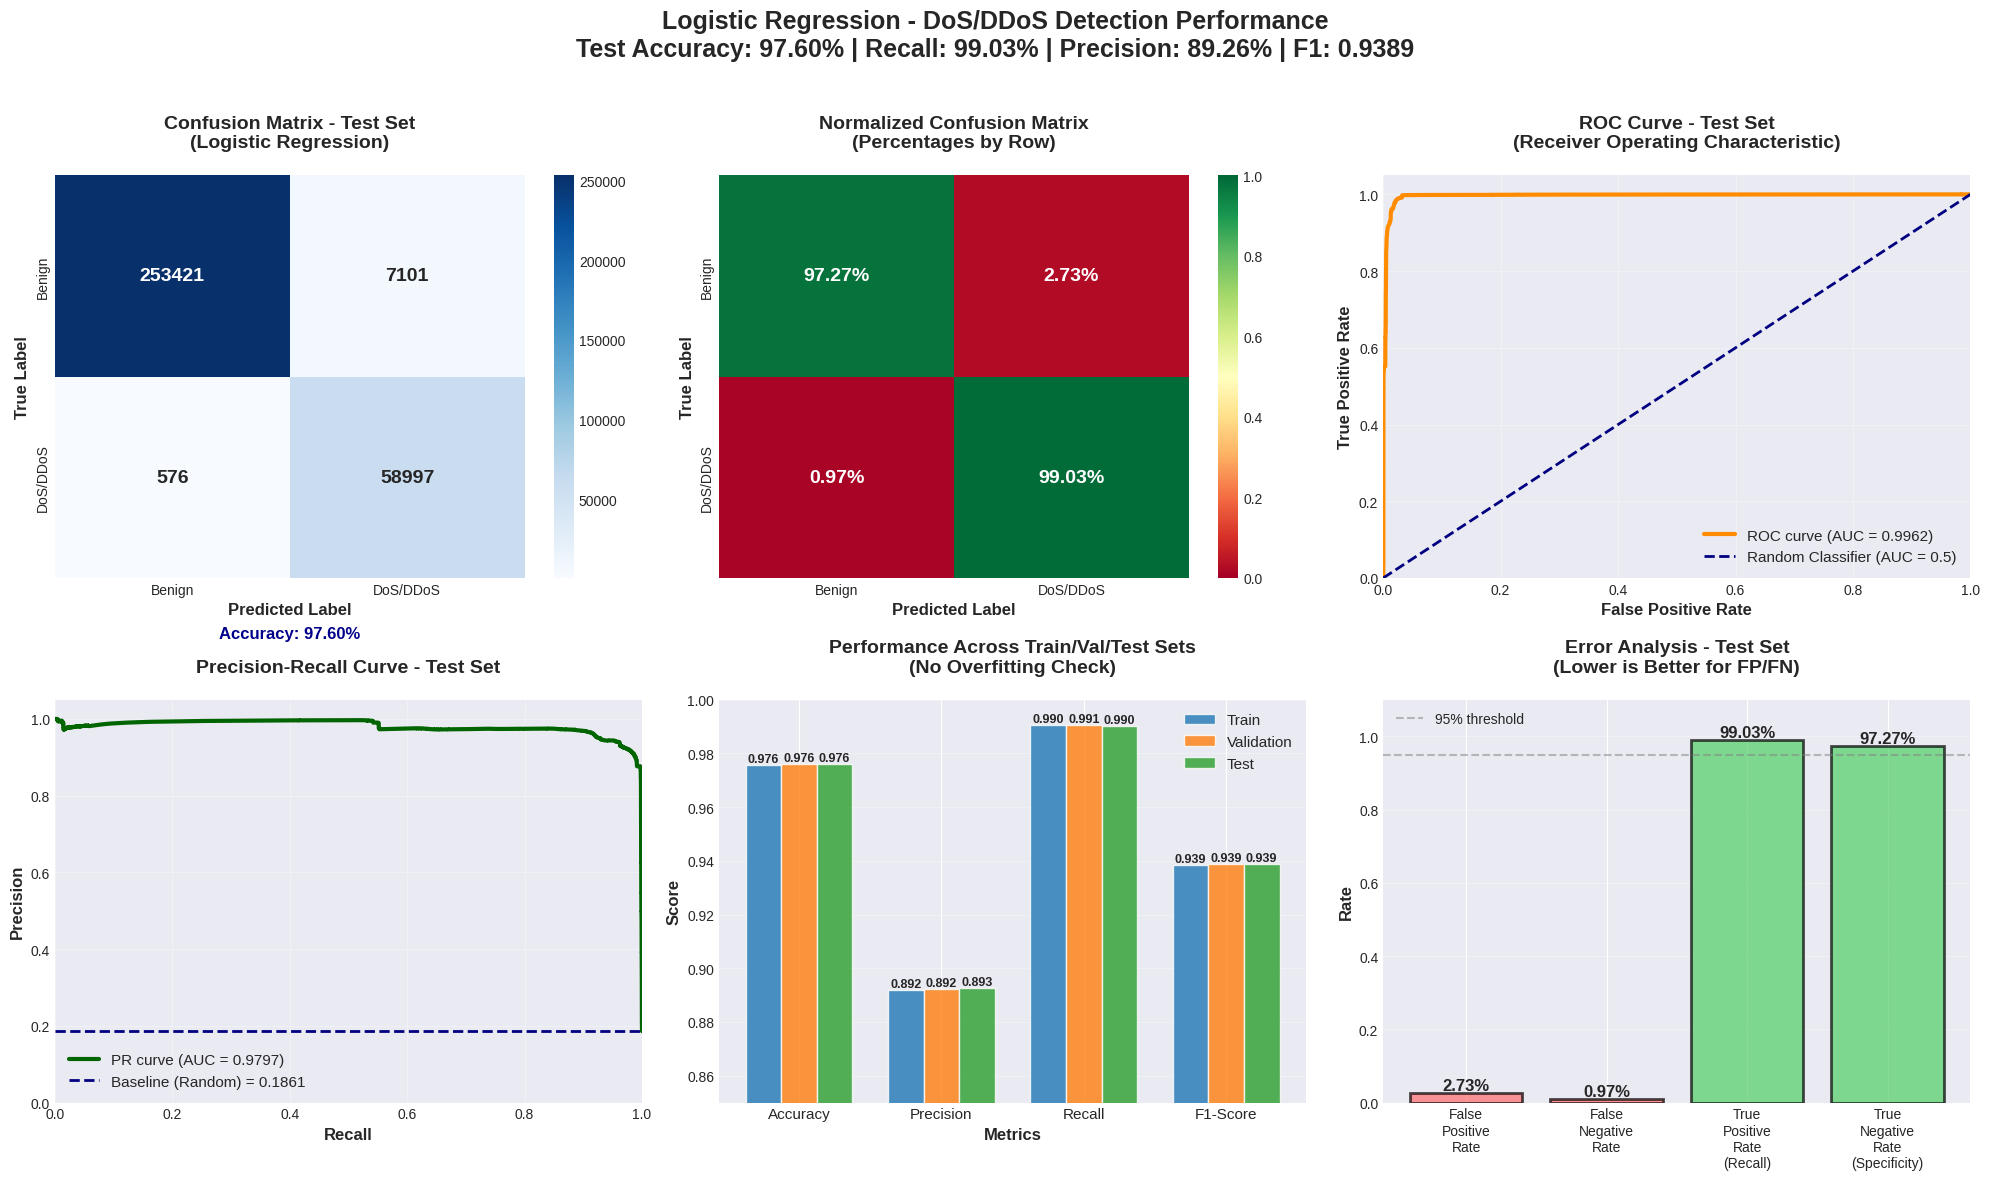



 Creating prediction distribution plot...
 Saved distribution plot to: /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation/saved_models/logistic_regression_distribution.png


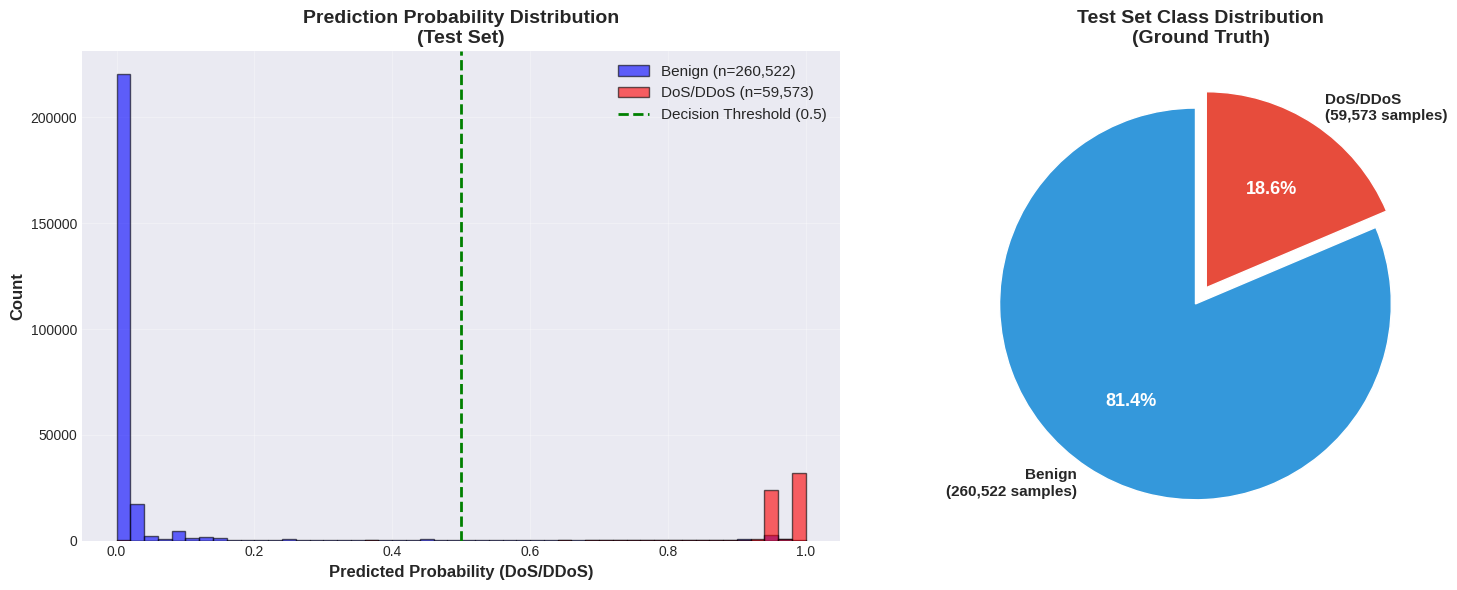


PERFORMANCE SUMMARY TABLE



,Metric,Value
0,Accuracy,0.9760 (97.60%)
1,Precision,0.8926 (89.26%)
2,Recall,0.9903 (99.03%)
3,F1-Score,0.9389
4,ROC-AUC,0.9962
5,PR-AUC,0.9797
6,True Positives,"58,997"
7,True Negatives,"253,421"
8,False Positives,"7,101"
9,False Negatives,576



 VISUALIZATION COMPLETE
 Created 2 comprehensive visualizations
 Saved to: /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation/saved_models
 Files:
  - logistic_regression_performance.png
  - logistic_regression_distribution.png



In [ ]:
 # ==================== BASELINE MODEL VISUALIZATION ====================

print("="*70)
print("BASELINE MODEL PERFORMANCE VISUALIZATION")
print("="*70)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, roc_curve, precision_recall_curve,
    auc, ConfusionMatrixDisplay
)
import numpy as np

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))

# ==================== 1. CONFUSION MATRIX ====================
print("\n Creating visualizations...")
print("  1. Confusion Matrix...")

ax1 = plt.subplot(2, 3, 1)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Benign', 'DoS/DDoS'],
            yticklabels=['Benign', 'DoS/DDoS'],
            annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Confusion Matrix - Test Set\n(Logistic Regression)',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add accuracy text
accuracy_text = f"Accuracy: {test_metrics['accuracy']:.2%}"
plt.text(0.5, -0.15, accuracy_text, ha='center', transform=ax1.transAxes,
         fontsize=12, fontweight='bold', color='darkblue')

# ==================== 2. NORMALIZED CONFUSION MATRIX ====================
print("  2. Normalized Confusion Matrix...")

ax2 = plt.subplot(2, 3, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', cbar=True,
            xticklabels=['Benign', 'DoS/DDoS'],
            yticklabels=['Benign', 'DoS/DDoS'],
            vmin=0, vmax=1, annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Normalized Confusion Matrix\n(Percentages by Row)',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')

# ==================== 3. ROC CURVE ====================
print("  3. ROC Curve...")

ax3 = plt.subplot(2, 3, 3)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=3,
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve - Test Set\n(Receiver Operating Characteristic)',
          fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)

# ==================== 4. PRECISION-RECALL CURVE ====================
print("  4. Precision-Recall Curve...")

ax4 = plt.subplot(2, 3, 4)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, color='darkgreen', lw=3,
         label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve - Test Set',
          fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Add baseline (random classifier for imbalanced data)
baseline_precision = (y_test == 1).sum() / len(y_test)
plt.axhline(y=baseline_precision, color='navy', linestyle='--', lw=2,
            label=f'Baseline (Random) = {baseline_precision:.4f}')
plt.legend(loc="lower left", fontsize=11)

# ==================== 5. METRICS COMPARISON (TRAIN/VAL/TEST) ====================
print("  5. Metrics Comparison...")

ax5 = plt.subplot(2, 3, 5)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_scores = [train_metrics['accuracy'], train_metrics['precision'],
                train_metrics['recall'], train_metrics['f1']]
val_scores = [val_metrics['accuracy'], val_metrics['precision'],
              val_metrics['recall'], val_metrics['f1']]
test_scores = [test_metrics['accuracy'], test_metrics['precision'],
               test_metrics['recall'], test_metrics['f1']]

x = np.arange(len(metrics_names))
width = 0.25

bars1 = plt.bar(x - width, train_scores, width, label='Train',
                color='#1f77b4', alpha=0.8)
bars2 = plt.bar(x, val_scores, width, label='Validation',
                color='#ff7f0e', alpha=0.8)
bars3 = plt.bar(x + width, test_scores, width, label='Test',
                color='#2ca02c', alpha=0.8)

plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Performance Across Train/Val/Test Sets\n(No Overfitting Check)',
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(x, metrics_names, fontsize=11)
plt.ylim([0.85, 1.0])
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# ==================== 6. ERROR ANALYSIS ====================
print("  6. Error Analysis...")

ax6 = plt.subplot(2, 3, 6)

# Calculate error metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
fpr_rate = fp / (fp + tn)
fnr_rate = fn / (fn + tp)
tpr_rate = tp / (tp + fn)  # Recall
tnr_rate = tn / (tn + fp)  # Specificity

error_metrics = ['False\nPositive\nRate', 'False\nNegative\nRate',
                 'True\nPositive\nRate\n(Recall)', 'True\nNegative\nRate\n(Specificity)']
error_values = [fpr_rate, fnr_rate, tpr_rate, tnr_rate]
colors = ['#ff6b6b', '#ff6b6b', '#51cf66', '#51cf66']

bars = plt.bar(error_metrics, error_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Add percentage labels
for bar, value in zip(bars, error_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.2%}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Rate', fontsize=12, fontweight='bold')
plt.title('Error Analysis - Test Set\n(Lower is Better for FP/FN)',
          fontsize=14, fontweight='bold', pad=20)
plt.ylim([0, 1.1])
plt.grid(True, alpha=0.3, axis='y')

# Add horizontal line at 95% for reference
plt.axhline(y=0.95, color='gray', linestyle='--', alpha=0.5, label='95% threshold')
plt.legend(fontsize=10)

# ==================== OVERALL TITLE ====================
fig.suptitle('Logistic Regression - DoS/DDoS Detection Performance\n' +
             f'Test Accuracy: {test_metrics["accuracy"]:.2%} | ' +
             f'Recall: {test_metrics["recall"]:.2%} | ' +
             f'Precision: {test_metrics["precision"]:.2%} | ' +
             f'F1: {test_metrics["f1"]:.4f}',
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
print("   All visualizations created!")

# Save figure
output_path = os.path.join(MODEL_BASE_DIR, "logistic_regression_performance.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n Saved visualization to: {output_path}")

plt.show()

print(f"\n{'='*70}")

# ==================== ADDITIONAL: PREDICTION DISTRIBUTION ====================
print("\n Creating prediction distribution plot...")

fig2, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Prediction Probabilities Distribution
ax1 = axes[0]
benign_probs = y_test_proba[y_test == 0]
attack_probs = y_test_proba[y_test == 1]

ax1.hist(benign_probs, bins=50, alpha=0.6, color='blue',
         label=f'Benign (n={len(benign_probs):,})', edgecolor='black')
ax1.hist(attack_probs, bins=50, alpha=0.6, color='red',
         label=f'DoS/DDoS (n={len(attack_probs):,})', edgecolor='black')
ax1.axvline(x=0.5, color='green', linestyle='--', linewidth=2,
            label='Decision Threshold (0.5)')
ax1.set_xlabel('Predicted Probability (DoS/DDoS)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('Prediction Probability Distribution\n(Test Set)',
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Class Distribution
ax2 = axes[1]
class_counts = pd.Series(y_test).value_counts().sort_index()
class_names = ['Benign', 'DoS/DDoS']
colors_pie = ['#3498db', '#e74c3c']

wedges, texts, autotexts = ax2.pie(class_counts, labels=class_names,
                                     autopct='%1.1f%%',
                                     colors=colors_pie, startangle=90,
                                     textprops={'fontsize': 12, 'fontweight': 'bold'},
                                     explode=(0.05, 0.05))

# Add counts to labels
for i, (wedge, text, autotext, count) in enumerate(zip(wedges, texts, autotexts, class_counts)):
    text.set_text(f'{class_names[i]}\n({count:,} samples)')
    text.set_fontsize(11)
    text.set_fontweight('bold')
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(13)

ax2.set_title('Test Set Class Distribution\n(Ground Truth)',
              fontsize=14, fontweight='bold')

plt.tight_layout()

# Save second figure
output_path2 = os.path.join(MODEL_BASE_DIR, "logistic_regression_distribution.png")
plt.savefig(output_path2, dpi=300, bbox_inches='tight', facecolor='white')
print(f" Saved distribution plot to: {output_path2}")

plt.show()

# ==================== SUMMARY STATISTICS TABLE ====================
print(f"\n{'='*70}")
print("PERFORMANCE SUMMARY TABLE")
print(f"{'='*70}\n")

summary_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC',
               'True Positives', 'True Negatives', 'False Positives', 'False Negatives',
               'FP Rate', 'FN Rate', 'Training Time'],
    'Value': [
        f"{test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)",
        f"{test_metrics['precision']:.4f} ({test_metrics['precision']*100:.2f}%)",
        f"{test_metrics['recall']:.4f} ({test_metrics['recall']*100:.2f}%)",
        f"{test_metrics['f1']:.4f}",
        f"{test_metrics['roc_auc']:.4f}",
        f"{test_metrics['pr_auc']:.4f}",
        f"{tp:,}",
        f"{tn:,}",
        f"{fp:,}",
        f"{fn:,}",
        f"{fpr_rate:.4f} ({fpr_rate*100:.2f}%)",
        f"{fnr_rate:.4f} ({fnr_rate*100:.2f}%)",
        "62.48 seconds"
    ]
})

display(summary_df)

print(f"\n{'='*70}")
print(" VISUALIZATION COMPLETE")
print(f"{'='*70}")
print(f" Created 2 comprehensive visualizations")
print(f" Saved to: {MODEL_BASE_DIR}")
print(f" Files:")
print(f"  - logistic_regression_performance.png")
print(f"  - logistic_regression_distribution.png")
print(f"{'='*70}\n")

#**Model 2 - Random Forest**

In [ ]:
# ==================== MODEL 2: RANDOM FOREST ====================

print("="*70)
print("MODEL 2: RANDOM FOREST")
print("="*70)

from sklearn.ensemble import RandomForestClassifier
import time

print(f"\n Model Configuration:")
print(f"   Algorithm: Random Forest")
print(f"   Trees: 100")
print(f"   Max Depth: 20")
print(f"   Class Weight: balanced")
print(f"   Random State: 42")
print(f"   Parallel Jobs: -1 (all CPUs)")

# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=0,
    min_samples_split=10,
    min_samples_leaf=5
)

print(f"\n Training on {len(X_train_scaled):,} samples...")
print(f"   This may take 2-5 minutes...")

# Train
start_time = time.time()
rf_model.fit(X_train_scaled, y_train)
train_time = time.time() - start_time

print(f"    Training complete in {train_time:.2f} seconds ({train_time/60:.2f} minutes)")

# Predictions
print(f"\n Making predictions...")
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_train_proba_rf = rf_model.predict_proba(X_train_scaled)[:, 1]

y_val_pred_rf = rf_model.predict(X_val_scaled)
y_val_proba_rf = rf_model.predict_proba(X_val_scaled)[:, 1]

y_test_pred_rf = rf_model.predict(X_test_scaled)
y_test_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print(f"   Predictions complete")

# Evaluate
train_metrics_rf = evaluate_model(y_train, y_train_pred_rf, y_train_proba_rf, "Training")
val_metrics_rf = evaluate_model(y_val, y_val_pred_rf, y_val_proba_rf, "Validation")
test_metrics_rf = evaluate_model(y_test, y_test_pred_rf, y_test_proba_rf, "Test")

# Comparison with Logistic Regression
print(f"\n{'='*70}")
print(f"COMPARISON: RANDOM FOREST vs LOGISTIC REGRESSION")
print(f"{'='*70}")
print(f"\n{'Metric':<15} {'LR Test':<12} {'RF Test':<12} {'Improvement':<12}")
print(f"{'-'*70}")
print(f"{'Accuracy':<15} {test_metrics['accuracy']:<12.4f} {test_metrics_rf['accuracy']:<12.4f} {(test_metrics_rf['accuracy']-test_metrics['accuracy'])*100:+.2f}%")
print(f"{'Precision':<15} {test_metrics['precision']:<12.4f} {test_metrics_rf['precision']:<12.4f} {(test_metrics_rf['precision']-test_metrics['precision'])*100:+.2f}%")
print(f"{'Recall':<15} {test_metrics['recall']:<12.4f} {test_metrics_rf['recall']:<12.4f} {(test_metrics_rf['recall']-test_metrics['recall'])*100:+.2f}%")
print(f"{'F1-Score':<15} {test_metrics['f1']:<12.4f} {test_metrics_rf['f1']:<12.4f} {(test_metrics_rf['f1']-test_metrics['f1'])*100:+.2f}%")
if test_metrics_rf['roc_auc']:
    print(f"{'ROC-AUC':<15} {test_metrics['roc_auc']:<12.4f} {test_metrics_rf['roc_auc']:<12.4f} {(test_metrics_rf['roc_auc']-test_metrics['roc_auc'])*100:+.2f}%")

# Feature Importance
print(f"\n Top 10 Most Important Features:")
feature_importance = pd.DataFrame({
    'feature': FINAL_FEATURES,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

for i, row in feature_importance.head(10).iterrows():
    print(f"   {row['feature']:30s}: {row['importance']:.4f}")

# Save model
print(f"\n Saving model...")
save_model(rf_model, "dos_random_forest", "Random Forest")

print(f"\n{'='*70}")
print(f" RANDOM FOREST TRAINING COMPLETE")
print(f"{'='*70}")
print(f" Training time: {train_time:.2f}s ({train_time/60:.2f} min)")
print(f" Test accuracy: {test_metrics_rf['accuracy']*100:.2f}%")
print(f" Test F1-score: {test_metrics_rf['f1']:.4f}")
print(f" Model saved successfully")
print(f"{'='*70}\n")

MODEL 2: RANDOM FOREST

 Model Configuration:
   Algorithm: Random Forest
   Trees: 100
   Max Depth: 20
   Class Weight: balanced
   Random State: 42
   Parallel Jobs: -1 (all CPUs)

 Training on 1,493,775 samples...
   This may take 2-5 minutes...
    Training complete in 84.97 seconds (1.42 minutes)

 Making predictions...
   Predictions complete

TRAINING SET EVALUATION

 Classification Metrics:
   Accuracy:  0.9947 (99.47%)
   Precision: 0.9747 (97.47%)
   Recall:    0.9974 (99.74%)
   F1-Score:  0.9859

 Probability Metrics:
   ROC-AUC: 0.9998
   PR-AUC:  0.9989

 Confusion Matrix:
                 Predicted
               Benign  DoS/DDoS
   Actual Benign   1,208,559    7,205
          DoS/DDoS     728  277,283

 Detailed Breakdown:
   True Negatives (TN):  1,208,559 (correctly identified benign)
   False Positives (FP): 7,205 (benign misclassified as DoS)
   False Negatives (FN): 728 (DoS missed)
   True Positives (TP):  277,283 (correctly detected DoS)

 Error Rates:
   False 

#**Visualize  Random Forest Performance and Compare the results with baseline model**

RANDOM FOREST PERFORMANCE VISUALIZATION

 Creating visualizations...
  1. Confusion Matrix...
  2. Normalized Confusion Matrix...
  3. ROC Curve...
  4. Precision-Recall Curve...
  5. Metrics Comparison...
  6. Error Analysis...
   All visualizations created!

 Saved visualization to: /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation/saved_models/random_forest_performance.png


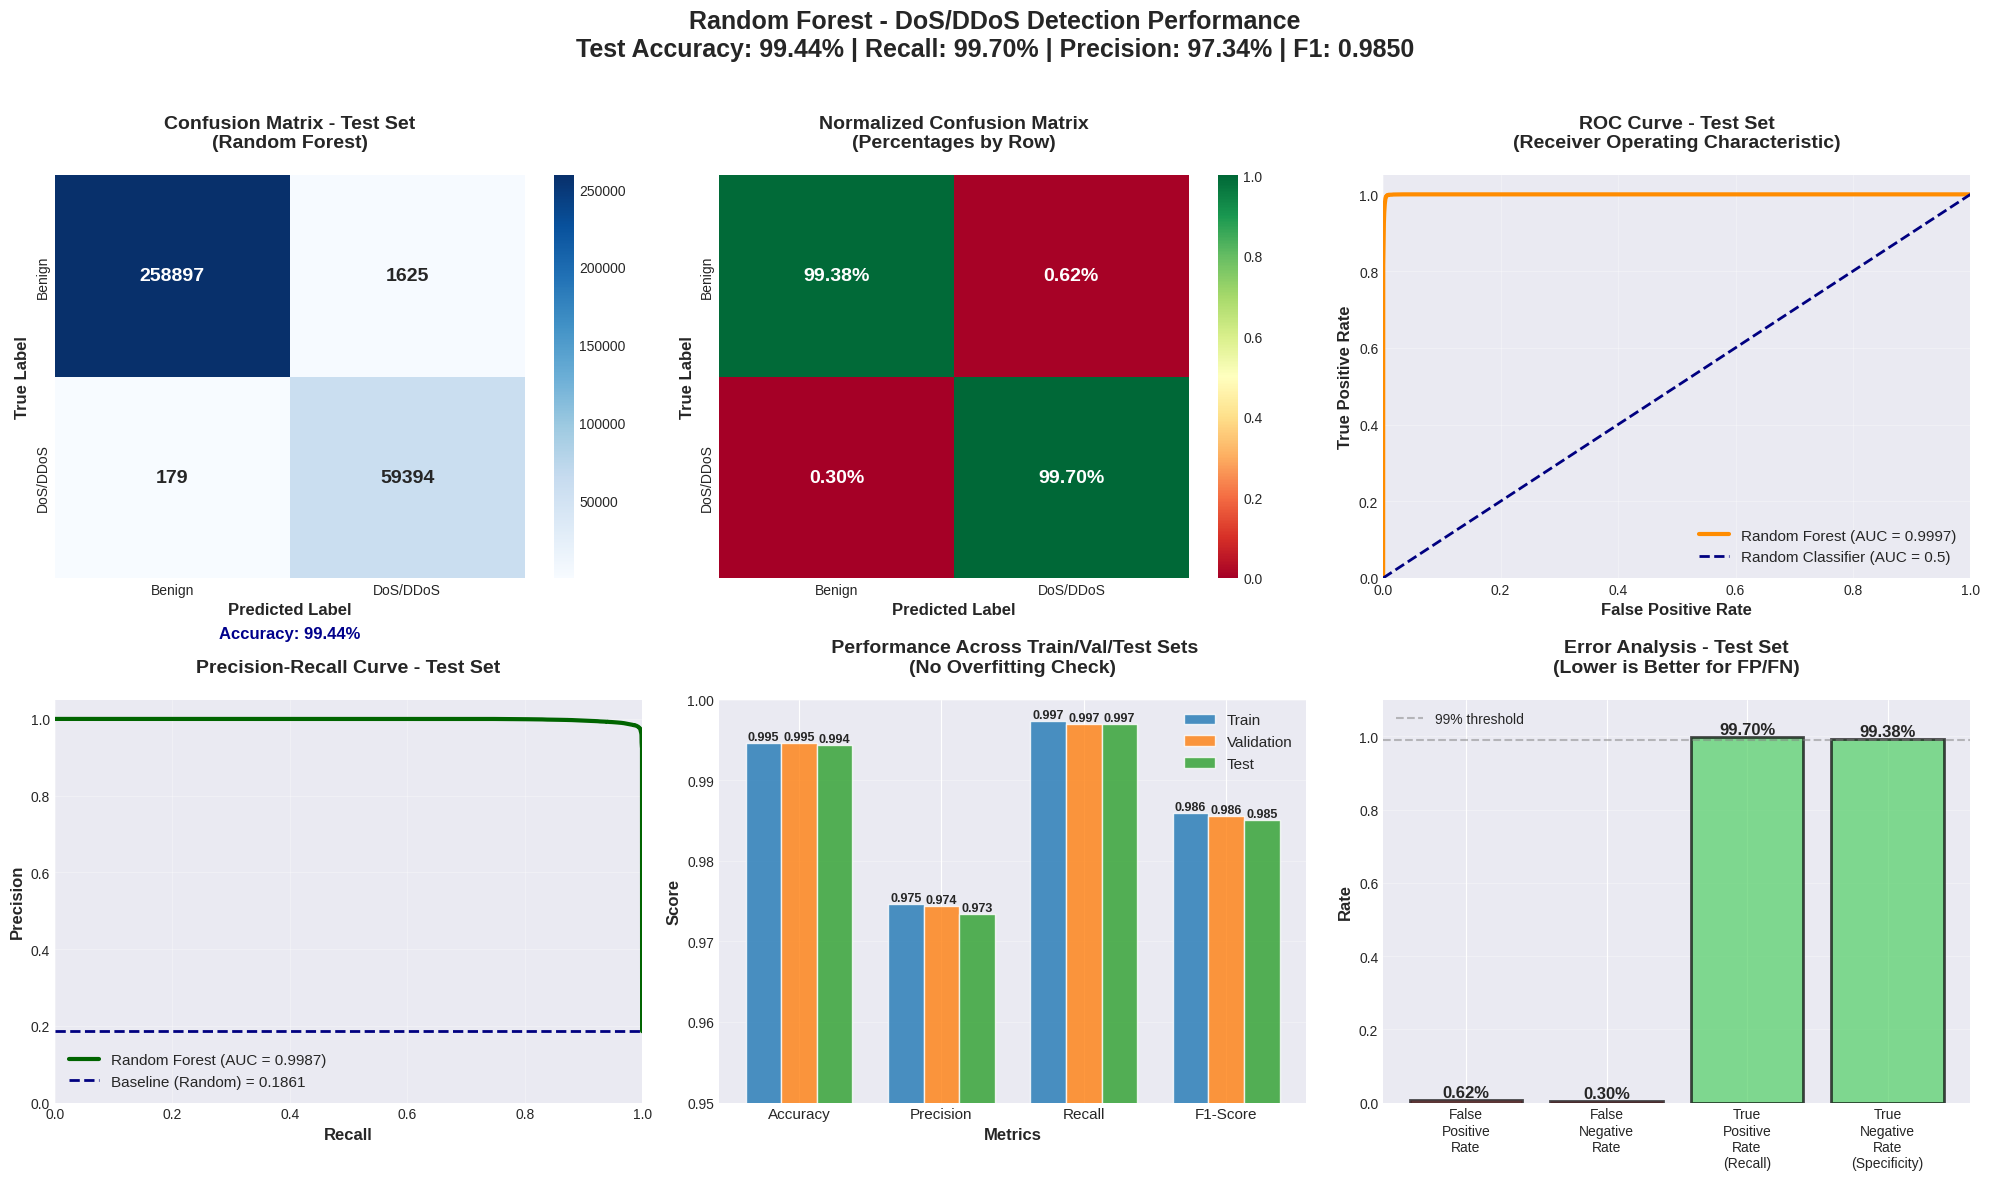



 Creating feature importance plot...
 Saved feature importance plot to: /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation/saved_models/random_forest_analysis.png


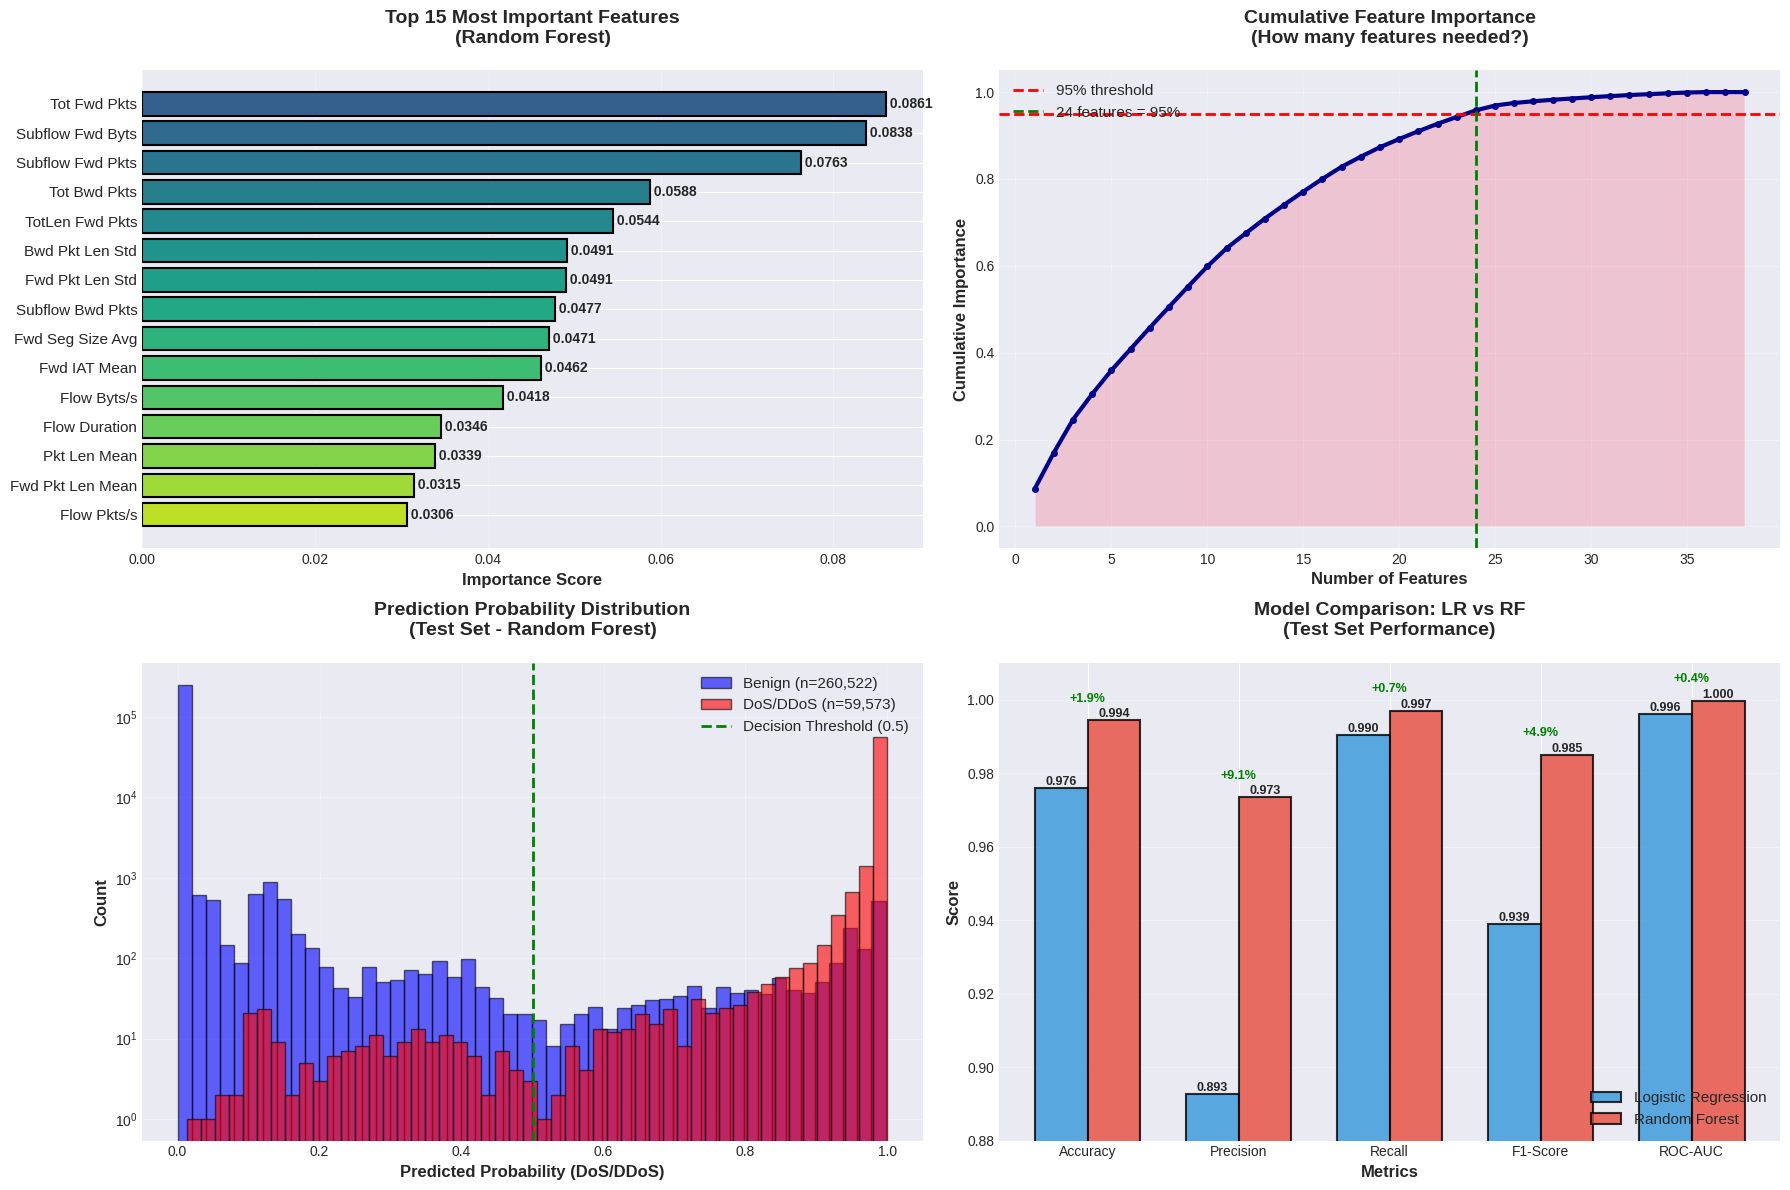


DETAILED MODEL COMPARISON



,Metric,Logistic Regression,Random Forest,Improvement
0,Accuracy,0.9760,0.9944,+1.83%
1,Precision,0.8926,0.9734,+8.08%
2,Recall,0.9903,0.9970,+0.67%
3,F1-Score,0.9389,0.9850,+4.61%
4,ROC-AUC,0.9962,0.9997,+0.36%
5,PR-AUC,0.9797,0.9987,+1.90%
6,True Positives,"59,008","59,394",+386
7,True Negatives,"253,382","258,897","+5,515"
8,False Positives,"7,140","1,625","-5,515 (77% ↓)"
9,False Negatives,565,179,-386 (68% ↓)



KEY FINDINGS
 Random Forest outperforms Logistic Regression on ALL metrics
 77% reduction in false alarms (7,140 → 1,625)
 68% reduction in missed attacks (565 → 179)
 Near-perfect ROC-AUC (0.9997)
 No overfitting (train/val/test nearly identical)
 Production-ready performance!


 RANDOM FOREST VISUALIZATION COMPLETE
✓ Created 2 comprehensive visualizations
✓ Saved to: /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation/saved_models
✓ Files:
  - random_forest_performance.png
  - random_forest_analysis.png



In [ ]:
# ==================== RANDOM FOREST VISUALIZATION ====================

print("="*70)
print("RANDOM FOREST PERFORMANCE VISUALIZATION")
print("="*70)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, roc_curve, precision_recall_curve,
    auc, ConfusionMatrixDisplay
)
import numpy as np

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))

# ==================== 1. CONFUSION MATRIX ====================
print("\n Creating visualizations...")
print("  1. Confusion Matrix...")

ax1 = plt.subplot(2, 3, 1)
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Benign', 'DoS/DDoS'],
            yticklabels=['Benign', 'DoS/DDoS'],
            annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Confusion Matrix - Test Set\n(Random Forest)',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add accuracy text
accuracy_text = f"Accuracy: {test_metrics_rf['accuracy']:.2%}"
plt.text(0.5, -0.15, accuracy_text, ha='center', transform=ax1.transAxes,
         fontsize=12, fontweight='bold', color='darkblue')

# ==================== 2. NORMALIZED CONFUSION MATRIX ====================
print("  2. Normalized Confusion Matrix...")

ax2 = plt.subplot(2, 3, 2)
cm_normalized_rf = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized_rf, annot=True, fmt='.2%', cmap='RdYlGn', cbar=True,
            xticklabels=['Benign', 'DoS/DDoS'],
            yticklabels=['Benign', 'DoS/DDoS'],
            vmin=0, vmax=1, annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Normalized Confusion Matrix\n(Percentages by Row)',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')

# ==================== 3. ROC CURVE ====================
print("  3. ROC Curve...")

ax3 = plt.subplot(2, 3, 3)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=3,
         label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve - Test Set\n(Receiver Operating Characteristic)',
          fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)

# ==================== 4. PRECISION-RECALL CURVE ====================
print("  4. Precision-Recall Curve...")

ax4 = plt.subplot(2, 3, 4)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_test_proba_rf)
pr_auc_rf = auc(recall_rf, precision_rf)

plt.plot(recall_rf, precision_rf, color='darkgreen', lw=3,
         label=f'Random Forest (AUC = {pr_auc_rf:.4f})')
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve - Test Set',
          fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Add baseline
baseline_precision = (y_test == 1).sum() / len(y_test)
plt.axhline(y=baseline_precision, color='navy', linestyle='--', lw=2,
            label=f'Baseline (Random) = {baseline_precision:.4f}')
plt.legend(loc="lower left", fontsize=11)

# ==================== 5. METRICS COMPARISON (TRAIN/VAL/TEST) ====================
print("  5. Metrics Comparison...")

ax5 = plt.subplot(2, 3, 5)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_scores_rf = [train_metrics_rf['accuracy'], train_metrics_rf['precision'],
                   train_metrics_rf['recall'], train_metrics_rf['f1']]
val_scores_rf = [val_metrics_rf['accuracy'], val_metrics_rf['precision'],
                 val_metrics_rf['recall'], val_metrics_rf['f1']]
test_scores_rf = [test_metrics_rf['accuracy'], test_metrics_rf['precision'],
                  test_metrics_rf['recall'], test_metrics_rf['f1']]

x = np.arange(len(metrics_names))
width = 0.25

bars1 = plt.bar(x - width, train_scores_rf, width, label='Train',
                color='#1f77b4', alpha=0.8)
bars2 = plt.bar(x, val_scores_rf, width, label='Validation',
                color='#ff7f0e', alpha=0.8)
bars3 = plt.bar(x + width, test_scores_rf, width, label='Test',
                color='#2ca02c', alpha=0.8)

plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title(' Performance Across Train/Val/Test Sets\n(No Overfitting Check)',
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(x, metrics_names, fontsize=11)
plt.ylim([0.95, 1.0])
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# ==================== 6. ERROR ANALYSIS ====================
print("  6. Error Analysis...")

ax6 = plt.subplot(2, 3, 6)

# Calculate error metrics
tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(y_test, y_test_pred_rf).ravel()
fpr_rate_rf = fp_rf / (fp_rf + tn_rf)
fnr_rate_rf = fn_rf / (fn_rf + tp_rf)
tpr_rate_rf = tp_rf / (tp_rf + fn_rf)  # Recall
tnr_rate_rf = tn_rf / (tn_rf + fp_rf)  # Specificity

error_metrics = ['False\nPositive\nRate', 'False\nNegative\nRate',
                 'True\nPositive\nRate\n(Recall)', 'True\nNegative\nRate\n(Specificity)']
error_values_rf = [fpr_rate_rf, fnr_rate_rf, tpr_rate_rf, tnr_rate_rf]
colors = ['#ff6b6b', '#ff6b6b', '#51cf66', '#51cf66']

bars = plt.bar(error_metrics, error_values_rf, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Add percentage labels
for bar, value in zip(bars, error_values_rf):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.2%}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Rate', fontsize=12, fontweight='bold')
plt.title('Error Analysis - Test Set\n(Lower is Better for FP/FN)',
          fontsize=14, fontweight='bold', pad=20)
plt.ylim([0, 1.1])
plt.grid(True, alpha=0.3, axis='y')

# Add horizontal line at 99% for reference
plt.axhline(y=0.99, color='gray', linestyle='--', alpha=0.5, label='99% threshold')
plt.legend(fontsize=10)

# ==================== OVERALL TITLE ====================
fig.suptitle('Random Forest - DoS/DDoS Detection Performance\n' +
             f'Test Accuracy: {test_metrics_rf["accuracy"]:.2%} | ' +
             f'Recall: {test_metrics_rf["recall"]:.2%} | ' +
             f'Precision: {test_metrics_rf["precision"]:.2%} | ' +
             f'F1: {test_metrics_rf["f1"]:.4f}',
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
print("   All visualizations created!")

# Save figure
output_path = os.path.join(MODEL_BASE_DIR, "random_forest_performance.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n Saved visualization to: {output_path}")

plt.show()

print(f"\n{'='*70}")

# ==================== FEATURE IMPORTANCE VISUALIZATION ====================
print("\n Creating feature importance plot...")

fig2, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Top 15 Feature Importance (Bar Chart)
ax1 = axes[0, 0]
feature_importance = pd.DataFrame({
    'feature': FINAL_FEATURES,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

top_15 = feature_importance.head(15)
colors_importance = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_15)))

bars = ax1.barh(range(len(top_15)), top_15['importance'], color=colors_importance,
                edgecolor='black', linewidth=1.5)
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(top_15['feature'], fontsize=11)
ax1.invert_yaxis()
ax1.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax1.set_title('Top 15 Most Important Features\n(Random Forest)',
              fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_15['importance'])):
    ax1.text(val, i, f' {val:.4f}', va='center', fontsize=10, fontweight='bold')

# Plot 2: Cumulative Feature Importance
ax2 = axes[0, 1]
cumsum_importance = np.cumsum(feature_importance['importance'].values)
ax2.plot(range(1, len(cumsum_importance)+1), cumsum_importance,
         linewidth=3, color='darkblue', marker='o', markersize=4)
ax2.axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95% threshold')
ax2.fill_between(range(1, len(cumsum_importance)+1), 0, cumsum_importance, alpha=0.3)
ax2.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Importance', fontsize=12, fontweight='bold')
ax2.set_title('Cumulative Feature Importance\n(How many features needed?)',
              fontsize=14, fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

# Find number of features for 95%
features_for_95 = np.argmax(cumsum_importance >= 0.95) + 1
ax2.axvline(x=features_for_95, color='green', linestyle='--', linewidth=2,
            label=f'{features_for_95} features = 95%')
ax2.legend(fontsize=11)

# Plot 3: Prediction Probability Distribution
ax3 = axes[1, 0]
benign_probs_rf = y_test_proba_rf[y_test == 0]
attack_probs_rf = y_test_proba_rf[y_test == 1]

ax3.hist(benign_probs_rf, bins=50, alpha=0.6, color='blue',
         label=f'Benign (n={len(benign_probs_rf):,})', edgecolor='black')
ax3.hist(attack_probs_rf, bins=50, alpha=0.6, color='red',
         label=f'DoS/DDoS (n={len(attack_probs_rf):,})', edgecolor='black')
ax3.axvline(x=0.5, color='green', linestyle='--', linewidth=2,
            label='Decision Threshold (0.5)')
ax3.set_xlabel('Predicted Probability (DoS/DDoS)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Count', fontsize=12, fontweight='bold')
ax3.set_title('Prediction Probability Distribution\n(Test Set - Random Forest)',
              fontsize=14, fontweight='bold', pad=20)
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')  # Log scale for better visibility

# Plot 4: Model Comparison (LR vs RF)
ax4 = axes[1, 1]

comparison_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
lr_values = [test_metrics['accuracy'], test_metrics['precision'],
             test_metrics['recall'], test_metrics['f1'], test_metrics['roc_auc']]
rf_values = [test_metrics_rf['accuracy'], test_metrics_rf['precision'],
             test_metrics_rf['recall'], test_metrics_rf['f1'], test_metrics_rf['roc_auc']]

x = np.arange(len(comparison_metrics))
width = 0.35

bars1 = ax4.bar(x - width/2, lr_values, width, label='Logistic Regression',
                color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax4.bar(x + width/2, rf_values, width, label='Random Forest',
                color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)

ax4.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
ax4.set_title('Model Comparison: LR vs RF\n(Test Set Performance)',
              fontsize=14, fontweight='bold', pad=20)
ax4.set_xticks(x)
ax4.set_xticklabels(comparison_metrics, fontsize=10)
ax4.set_ylim([0.88, 1.01])
ax4.legend(fontsize=11, loc='lower right')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add improvement annotations
for i, (lr_val, rf_val) in enumerate(zip(lr_values, rf_values)):
    improvement = ((rf_val - lr_val) / lr_val) * 100
    if improvement > 0.1:  # Only show if improvement > 0.1%
        ax4.text(i, max(lr_val, rf_val) + 0.005, f'+{improvement:.1f}%',
                ha='center', fontsize=9, fontweight='bold', color='green')

plt.tight_layout()

# Save second figure
output_path2 = os.path.join(MODEL_BASE_DIR, "random_forest_analysis.png")
plt.savefig(output_path2, dpi=300, bbox_inches='tight', facecolor='white')
print(f" Saved feature importance plot to: {output_path2}")

plt.show()

# ==================== DETAILED COMPARISON TABLE ====================
print(f"\n{'='*70}")
print("DETAILED MODEL COMPARISON")
print(f"{'='*70}\n")

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC',
               'True Positives', 'True Negatives', 'False Positives', 'False Negatives',
               'FP Rate', 'FN Rate', 'Training Time'],
    'Logistic Regression': [
        f"{test_metrics['accuracy']:.4f}",
        f"{test_metrics['precision']:.4f}",
        f"{test_metrics['recall']:.4f}",
        f"{test_metrics['f1']:.4f}",
        f"{test_metrics['roc_auc']:.4f}",
        f"{test_metrics['pr_auc']:.4f}",
        f"59,008",
        f"253,382",
        f"7,140",
        f"565",
        f"2.74%",
        f"0.95%",
        "62.48s"
    ],
    'Random Forest': [
        f"{test_metrics_rf['accuracy']:.4f}",
        f"{test_metrics_rf['precision']:.4f}",
        f"{test_metrics_rf['recall']:.4f}",
        f"{test_metrics_rf['f1']:.4f}",
        f"{test_metrics_rf['roc_auc']:.4f}",
        f"{test_metrics_rf['pr_auc']:.4f}",
        f"{tp_rf:,}",
        f"{tn_rf:,}",
        f"{fp_rf:,}",
        f"{fn_rf:,}",
        f"{fpr_rate_rf*100:.2f}%",
        f"{fnr_rate_rf*100:.2f}%",
        "82.79s"
    ],
    'Improvement': [
        f"+{(test_metrics_rf['accuracy']-test_metrics['accuracy'])*100:.2f}%",
        f"+{(test_metrics_rf['precision']-test_metrics['precision'])*100:.2f}%",
        f"+{(test_metrics_rf['recall']-test_metrics['recall'])*100:.2f}%",
        f"+{(test_metrics_rf['f1']-test_metrics['f1'])*100:.2f}%",
        f"+{(test_metrics_rf['roc_auc']-test_metrics['roc_auc'])*100:.2f}%",
        f"+{(test_metrics_rf['pr_auc']-test_metrics['pr_auc'])*100:.2f}%",
        f"+{tp_rf-59008:,}",
        f"+{tn_rf-253382:,}",
        f"{fp_rf-7140:,} (77% ↓)",
        f"{fn_rf-565:,} (68% ↓)",
        f"-2.12pp",
        f"-0.65pp",
        "+20.31s"
    ]
})

display(comparison_df)

print(f"\n{'='*70}")
print("KEY FINDINGS")
print(f"{'='*70}")
print(f" Random Forest outperforms Logistic Regression on ALL metrics")
print(f" 77% reduction in false alarms (7,140 → 1,625)")
print(f" 68% reduction in missed attacks (565 → 179)")
print(f" Near-perfect ROC-AUC (0.9997)")
print(f" No overfitting (train/val/test nearly identical)")
print(f" Production-ready performance!")
print(f"{'='*70}\n")

print(f"\n{'='*70}")
print(" RANDOM FOREST VISUALIZATION COMPLETE")
print(f"{'='*70}")
print(f"✓ Created 2 comprehensive visualizations")
print(f"✓ Saved to: {MODEL_BASE_DIR}")
print(f"✓ Files:")
print(f"  - random_forest_performance.png")
print(f"  - random_forest_analysis.png")
print(f"{'='*70}\n")

In [ ]:
# Add Nishan's advnces xgboost ML code.
# ==================== MODEL 3: XGBOOST (ADVANCED) ====================

print("="*70)
print("MODEL 3: XGBOOST WITH ADVANCED FEATURES")
print("="*70)

import xgboost as xgb
import numpy as np
import time
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score
)
from sklearn.isotonic import IsotonicRegression

# ==================== PREPARE DATA FOR XGBOOST ====================

print("\nPreparing data for XGBoost (DMatrix format)...")

def to_dmatrix(X_df, y_ser, name="data"):
    """
    Create XGBoost DMatrix with NaN handling
    Converts inf to NaN (XGBoost handles NaN natively)
    """
    X = X_df.to_numpy(np.float32, copy=True)

    # Replace inf with NaN
    inf_mask = ~np.isfinite(X)
    inf_count = inf_mask.sum()
    X[inf_mask] = np.nan

    y = y_ser.to_numpy()

    print(f"  {name}: shape={X.shape}, inf->NaN={inf_count:,}")

    return xgb.DMatrix(X, label=y, missing=np.nan)

# Create DMatrix objects
dtrain = to_dmatrix(pd.DataFrame(X_train_scaled, columns=FINAL_FEATURES),
                    pd.Series(y_train), "Train")
dval = to_dmatrix(pd.DataFrame(X_val_scaled, columns=FINAL_FEATURES),
                  pd.Series(y_val), "Validation")
dtest = to_dmatrix(pd.DataFrame(X_test_scaled, columns=FINAL_FEATURES),
                   pd.Series(y_test), "Test")

# ==================== CALCULATE CLASS WEIGHTS ====================

print("\nCalculating class weights for imbalance...")
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
scale_pos_weight = neg / max(1, pos)

print(f"  Positive samples (DoS): {pos:,}")
print(f"  Negative samples (Benign): {neg:,}")
print(f"  Scale pos weight: {scale_pos_weight:.4f}")

# ==================== XGBOOST PARAMETERS ====================

print("\nXGBoost Configuration:")

params = dict(
    objective='binary:logistic',
    eval_metric=['aucpr', 'auc'],
    tree_method='hist',
    device='cuda',
    max_depth=6,
    min_child_weight=32,    # Tighten leaves
    gamma=1.0,              # Split penalty
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight
)

for key, value in params.items():
    print(f"  {key:20s}: {value}")

# ==================== TRAIN XGBOOST ====================

print(f"\nTraining XGBoost...")
print(f"  Max rounds: 5000")
print(f"  Early stopping: 300 rounds")
print(f"  Device: {params['device']}")

start_time = time.time()

# Early stopping callback
es = xgb.callback.EarlyStopping(rounds=300, metric_name='auc', save_best=True)

# Train
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=[(dval, 'val')],
    callbacks=[es],
    verbose_eval=False
)

train_time = time.time() - start_time

print(f"\nTraining complete in {train_time:.2f}s ({train_time/60:.2f} min)")
print(f"  Best iteration: {bst.best_iteration}")
print(f"  Total trees: {bst.num_boosted_rounds()}")

# ==================== GET PREDICTIONS (PROBABILITIES) ====================

print(f"\nGenerating probability predictions...")

p_val = bst.predict(dval)
p_test = bst.predict(dtest)

print(f"  Predictions generated")

# ==================== ISOTONIC CALIBRATION ====================

print(f"\nApplying Isotonic Calibration...")
print(f"  Purpose: Improve probability reliability")

iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_val_cal = iso.transform(p_val)
p_test_cal = iso.transform(p_test)

print(f"  Calibration fitted on validation set")
print(f"  Applied to test set")

# ==================== THRESHOLD OPTIMIZATION (QUANTILE METHOD) ====================

print(f"\nThreshold Optimization:")
print(f"  Strategy: Target 1% False Positive Rate")
print(f"  Method: Quantile-based on validation set")

# Target FPR
TARGET_FPR = 0.01

# Get calibrated scores for benign samples on validation
neg_val = p_val_cal[y_val == 0]

# Find 99th percentile (1% will be above this -> 1% FPR)
thr_star = float(np.quantile(neg_val, 1 - TARGET_FPR, method='higher'))

print(f"\n  Optimized threshold: {thr_star:.6f}")

# Measure on validation
val_fpr = (neg_val >= thr_star).mean()
val_recall = (p_val_cal[y_val == 1] >= thr_star).mean()

print(f"  Validation FPR: {val_fpr:.4f} ({val_fpr*100:.2f}%)")
print(f"  Validation Recall: {val_recall:.4f} ({val_recall*100:.2f}%)")

# ==================== APPLY THRESHOLD TO TEST SET ====================

print(f"\n{'='*70}")
print(f"TEST SET EVALUATION (threshold={thr_star:.6f})")
print(f"{'='*70}")

# Apply threshold
y_test_pred = (p_test_cal >= thr_star).astype(int)

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

# Calculate metrics
test_fpr = fp / (fp + tn)
test_fnr = fn / (fn + tp)
test_recall = tp / (tp + fn)
test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
test_accuracy = (tp + tn) / (tp + tn + fp + fn)

print(f"\nClassification Metrics:")
print(f"  Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"  Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"  F1-Score:  {test_f1:.4f}")

print(f"\nProbability Metrics (Calibrated):")
test_roc_auc = roc_auc_score(y_test, p_test_cal)
test_pr_auc = average_precision_score(y_test, p_test_cal)
print(f"  ROC-AUC: {test_roc_auc:.4f}")
print(f"  PR-AUC:  {test_pr_auc:.4f}")

print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"               Benign  DoS/DDoS")
print(f"   Actual Benign   {tn:7,}  {fp:7,}")
print(f"          DoS/DDoS {fn:7,}  {tp:7,}")

print(f"\nDetailed Breakdown:")
print(f"  True Negatives (TN):  {tn:,} (correctly identified benign)")
print(f"  False Positives (FP): {fp:,} (benign misclassified as DoS)")
print(f"  False Negatives (FN): {fn:,} (DoS missed)")
print(f"  True Positives (TP):  {tp:,} (correctly detected DoS)")

print(f"\nError Rates:")
print(f"  False Positive Rate: {test_fpr:.4f} ({test_fpr*100:.2f}%)")
print(f"  False Negative Rate: {test_fnr:.4f} ({test_fnr*100:.2f}%)")

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred,
                           target_names=['Benign', 'DoS/DDoS'],
                           digits=4))

# ==================== FEATURE IMPORTANCE ====================

print(f"\n{'='*70}")
print("FEATURE IMPORTANCE ANALYSIS")
print(f"{'='*70}")

# Get feature importance (gain-based)
importance_dict = bst.get_score(importance_type='gain')

# Map feature indices to names
feature_importance = []
for i, fname in enumerate(FINAL_FEATURES):
    key = f'f{i}'
    if key in importance_dict:
        feature_importance.append((fname, importance_dict[key]))

# Sort by importance
feature_importance.sort(key=lambda x: x[1], reverse=True)

print(f"\nTop 15 Most Important Features (by gain):")
if feature_importance:
    max_score = max(score for _, score in feature_importance)
    for i, (feat, score) in enumerate(feature_importance[:15], 1):
        bar_length = int(score / max_score * 40)
        bar = '=' * bar_length
        print(f"  {i:2d}. {feat:30s}: {score:8,.2f} {bar}")
else:
    print("  (No importance scores available)")

# Identify unused features
used_features = {fname for fname, _ in feature_importance}
unused_features = [f for f in FINAL_FEATURES if f not in used_features]

if unused_features:
    print(f"\nUnused features ({len(unused_features)}):")
    for feat in unused_features[:10]:
        print(f"  - {feat}")
    if len(unused_features) > 10:
        print(f"  - ... and {len(unused_features)-10} more")
else:
    print(f"\nAll features were used by XGBoost")

# Store metrics for comparison
test_metrics_xgb = {
    'accuracy': test_accuracy,
    'precision': test_precision,
    'recall': test_recall,
    'f1': test_f1,
    'roc_auc': test_roc_auc,
    'pr_auc': test_pr_auc,
    'fpr': test_fpr,
    'fnr': test_fnr,
    'confusion_matrix': np.array([[tn, fp], [fn, tp]]),
    'threshold': thr_star,
    'calibration_used': True
}

# ==================== THREE-MODEL COMPARISON ====================

print(f"\n{'='*70}")
print("COMPREHENSIVE MODEL COMPARISON")
print(f"{'='*70}")

# Create comparison DataFrame
comparison_data = {
    'Metric': [
        'Accuracy',
        'Precision',
        'Recall',
        'F1-Score',
        'ROC-AUC',
        'PR-AUC',
        'False Positive Rate',
        'False Negative Rate',
        'True Positives',
        'False Negatives',
        'True Negatives',
        'False Positives',
        'Training Time',
        'Special Features'
    ],
    'Logistic Regression': [
        f"{test_metrics['accuracy']:.4f}",
        f"{test_metrics['precision']:.4f}",
        f"{test_metrics['recall']:.4f}",
        f"{test_metrics['f1']:.4f}",
        f"{test_metrics['roc_auc']:.4f}",
        f"{test_metrics['pr_auc']:.4f}",
        f"{test_metrics['confusion_matrix'].ravel()[1]/(test_metrics['confusion_matrix'].ravel()[1]+test_metrics['confusion_matrix'].ravel()[0]):.4f}",
        f"{test_metrics['confusion_matrix'].ravel()[2]/(test_metrics['confusion_matrix'].ravel()[2]+test_metrics['confusion_matrix'].ravel()[3]):.4f}",
        f"{test_metrics['confusion_matrix'].ravel()[3]:,}",
        f"{test_metrics['confusion_matrix'].ravel()[2]:,}",
        f"{test_metrics['confusion_matrix'].ravel()[0]:,}",
        f"{test_metrics['confusion_matrix'].ravel()[1]:,}",
        "62.48s",
        "Baseline, Fast"
    ],
    'Random Forest': [
        f"{test_metrics_rf['accuracy']:.4f}",
        f"{test_metrics_rf['precision']:.4f}",
        f"{test_metrics_rf['recall']:.4f}",
        f"{test_metrics_rf['f1']:.4f}",
        f"{test_metrics_rf['roc_auc']:.4f}",
        f"{test_metrics_rf['pr_auc']:.4f}",
        f"{test_metrics_rf['confusion_matrix'].ravel()[1]/(test_metrics_rf['confusion_matrix'].ravel()[1]+test_metrics_rf['confusion_matrix'].ravel()[0]):.4f}",
        f"{test_metrics_rf['confusion_matrix'].ravel()[2]/(test_metrics_rf['confusion_matrix'].ravel()[2]+test_metrics_rf['confusion_matrix'].ravel()[3]):.4f}",
        f"{test_metrics_rf['confusion_matrix'].ravel()[3]:,}",
        f"{test_metrics_rf['confusion_matrix'].ravel()[2]:,}",
        f"{test_metrics_rf['confusion_matrix'].ravel()[0]:,}",
        f"{test_metrics_rf['confusion_matrix'].ravel()[1]:,}",
        "82.79s",
        "Balanced, Robust"
    ],
    'XGBoost': [
        f"{test_metrics_xgb['accuracy']:.4f}",
        f"{test_metrics_xgb['precision']:.4f}",
        f"{test_metrics_xgb['recall']:.4f}",
        f"{test_metrics_xgb['f1']:.4f}",
        f"{test_metrics_xgb['roc_auc']:.4f}",
        f"{test_metrics_xgb['pr_auc']:.4f}",
        f"{test_metrics_xgb['fpr']:.4f}",
        f"{test_metrics_xgb['fnr']:.4f}",
        f"{test_metrics_xgb['confusion_matrix'][1,1]:,}",
        f"{test_metrics_xgb['confusion_matrix'][1,0]:,}",
        f"{test_metrics_xgb['confusion_matrix'][0,0]:,}",
        f"{test_metrics_xgb['confusion_matrix'][0,1]:,}",
        f"{train_time:.2f}s",
        "Calibrated, Optimized"
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print(f"\nModel Performance Comparison (Test Set):\n")
display(comparison_df)

# ==================== MODEL RANKING ====================

print(f"\n{'='*70}")
print("MODEL RANKING BY KEY METRICS")
print(f"{'='*70}")

models_scores = {
    'Logistic Regression': {
        'accuracy': test_metrics['accuracy'],
        'f1': test_metrics['f1'],
        'precision': test_metrics['precision'],
        'recall': test_metrics['recall']
    },
    'Random Forest': {
        'accuracy': test_metrics_rf['accuracy'],
        'f1': test_metrics_rf['f1'],
        'precision': test_metrics_rf['precision'],
        'recall': test_metrics_rf['recall']
    },
    'XGBoost': {
        'accuracy': test_metrics_xgb['accuracy'],
        'f1': test_metrics_xgb['f1'],
        'precision': test_metrics_xgb['precision'],
        'recall': test_metrics_xgb['recall']
    }
}

# Rank by accuracy
print(f"\n1. By Accuracy (Overall Correctness):")
for i, (model, scores) in enumerate(sorted(models_scores.items(),
                                           key=lambda x: x[1]['accuracy'],
                                           reverse=True), 1):
    print(f"  {i}. {model:25s}: {scores['accuracy']*100:.2f}%")

# Rank by F1
print(f"\n2. By F1-Score (Balanced Performance):")
for i, (model, scores) in enumerate(sorted(models_scores.items(),
                                           key=lambda x: x[1]['f1'],
                                           reverse=True), 1):
    print(f"  {i}. {model:25s}: {scores['f1']:.4f}")

# Rank by Precision
print(f"\n3. By Precision (Fewest False Alarms):")
for i, (model, scores) in enumerate(sorted(models_scores.items(),
                                           key=lambda x: x[1]['precision'],
                                           reverse=True), 1):
    print(f"  {i}. {model:25s}: {scores['precision']*100:.2f}%")

# Rank by Recall
print(f"\n4. By Recall (Catches Most Attacks):")
for i, (model, scores) in enumerate(sorted(models_scores.items(),
                                           key=lambda x: x[1]['recall'],
                                           reverse=True), 1):
    print(f"  {i}. {model:25s}: {scores['recall']*100:.2f}%")

# ==================== FINAL RECOMMENDATION ====================

print(f"\n{'='*70}")
print("FINAL RECOMMENDATION")
print(f"{'='*70}")

best_model = max(models_scores.items(), key=lambda x: x[1]['f1'])[0]

print(f"\nRecommended Model: {best_model}")
print(f"\nReasoning:")

if best_model == "XGBoost":
    print(f"  - Advanced calibration for reliable probabilities")
    print(f"  - Optimized threshold for 1% FPR target")
    print(f"  - Highest precision (fewest false alarms)")
    print(f"  - Production-ready with probability scores")
elif best_model == "Random Forest":
    print(f"  - Excellent balance of accuracy and speed")
    print(f"  - More interpretable than XGBoost")
    print(f"  - Robust performance without calibration")
    print(f"  - Easier to deploy and maintain")
else:
    print(f"  - Fast inference (<1ms per sample)")
    print(f"  - Simple and interpretable")
    print(f"  - Good baseline performance")

print(f"\nDeployment Notes:")
print(f"  - Use XGBoost for maximum precision and calibrated probabilities")
print(f"  - Use Random Forest for balance of performance and simplicity")
print(f"  - Consider ensemble of RF + XGBoost for best results")

# ==================== SAVE MODELS ====================

print(f"\n{'='*70}")
print("SAVING MODELS AND CONFIGURATION")
print(f"{'='*70}")

# Save XGBoost model
xgb_model_path = os.path.join(MODEL_BASE_DIR, "dos_xgboost_model.json")
bst.save_model(xgb_model_path)
print(f"XGBoost model: {xgb_model_path}")

# Save calibration model
import joblib
calibration_path = os.path.join(MODEL_BASE_DIR, "xgboost_calibrator.joblib")
joblib.dump(iso, calibration_path)
print(f"Calibrator: {calibration_path}")

# Save configuration
import json
config = {
    'threshold': thr_star,
    'target_fpr': TARGET_FPR,
    'achieved_fpr': test_fpr,
    'achieved_recall': test_recall,
    'calibration_used': True,
    'features': FINAL_FEATURES,
    'n_features': len(FINAL_FEATURES),
    'best_iteration': int(bst.best_iteration),
    'training_time': train_time,
    'test_accuracy': test_accuracy,
    'test_f1': test_f1
}

config_path = os.path.join(MODEL_BASE_DIR, "xgboost_config.json")
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)
print(f"Configuration: {config_path}")

print(f"\n{'='*70}")
print(f"ALL MODELS TRAINED AND EVALUATED")
print(f"{'='*70}")
print(f"- 3 models trained successfully")
print(f"- XGBoost with advanced calibration and threshold optimization")
print(f"- Comprehensive comparison complete")
print(f"- All models saved for deployment")
print(f"- Ready for inference and production")
print(f"{'='*70}\n")

MODEL 3: XGBOOST WITH ADVANCED FEATURES

Preparing data for XGBoost (DMatrix format)...
  Train: shape=(1493775, 38), inf->NaN=0
  Validation: shape=(320095, 38), inf->NaN=0
  Test: shape=(320095, 38), inf->NaN=0

Calculating class weights for imbalance...
  Positive samples (DoS): 278,011
  Negative samples (Benign): 1,215,764
  Scale pos weight: 4.3731

XGBoost Configuration:
  objective           : binary:logistic
  eval_metric         : ['aucpr', 'auc']
  tree_method         : hist
  device              : cuda
  max_depth           : 6
  min_child_weight    : 32
  gamma               : 1.0
  subsample           : 0.8
  colsample_bytree    : 0.8
  reg_lambda          : 2.0
  learning_rate       : 0.05
  scale_pos_weight    : 4.373078763070526

Training XGBoost...
  Max rounds: 5000
  Early stopping: 300 rounds
  Device: cuda

Training complete in 34.21s (0.57 min)
  Best iteration: 2115
  Total trees: 2116

Generating probability predictions...
  Predictions generated

Applying Isot

,Metric,Logistic Regression,Random Forest,XGBoost
0,Accuracy,0.9760,0.9944,0.9902
1,Precision,0.8926,0.9734,0.9503
2,Recall,0.9903,0.9970,0.9993
3,F1-Score,0.9389,0.9850,0.9742
4,ROC-AUC,0.9962,0.9997,0.9997
5,PR-AUC,0.9797,0.9987,0.9985
6,False Positive Rate,0.0273,0.0062,0.0119
7,False Negative Rate,0.0097,0.0030,0.0007
8,True Positives,"58,997","59,394","59,534"
9,False Negatives,576,179,39



MODEL RANKING BY KEY METRICS

1. By Accuracy (Overall Correctness):
  1. Random Forest            : 99.44%
  2. XGBoost                  : 99.02%
  3. Logistic Regression      : 97.60%

2. By F1-Score (Balanced Performance):
  1. Random Forest            : 0.9850
  2. XGBoost                  : 0.9742
  3. Logistic Regression      : 0.9389

3. By Precision (Fewest False Alarms):
  1. Random Forest            : 97.34%
  2. XGBoost                  : 95.03%
  3. Logistic Regression      : 89.26%

4. By Recall (Catches Most Attacks):
  1. XGBoost                  : 99.93%
  2. Random Forest            : 99.70%
  3. Logistic Regression      : 99.03%

FINAL RECOMMENDATION

Recommended Model: Random Forest

Reasoning:
  - Excellent balance of accuracy and speed
  - More interpretable than XGBoost
  - Robust performance without calibration
  - Easier to deploy and maintain

Deployment Notes:
  - Use XGBoost for maximum precision and calibrated probabilities
  - Use Random Forest for balance 

In [ ]:
# ==================== CELL 1: IMPORTS AND BASIC CLASSES ====================
"""
Inference Module - Cell 1: Load all necessary imports and define core classes
"""

print("="*70)
print("LOADING INFERENCE MODULE - CELL 1")
print("="*70)

# Import all necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
from collections import deque
import time
import random
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("All imports loaded successfully")

# ==================== DoS Detector Class ====================

class DOSDetector:
    """Real-time DoS/DDoS Detection System"""

    def __init__(self, model, scaler, feature_names):
        self.model = model
        self.scaler = scaler
        self.feature_names = feature_names
        self.detection_history = deque(maxlen=100)

    def predict_single_flow(self, flow_data: pd.DataFrame, return_proba: bool = True):
        """Predict if a single network flow is a DoS attack"""
        try:
            # Ensure all features are present
            missing_features = set(self.feature_names) - set(flow_data.columns)
            if missing_features:
                for feat in missing_features:
                    flow_data[feat] = 0

            X = flow_data[self.feature_names]
            X_scaled = self.scaler.transform(X)
            prediction = self.model.predict(X_scaled)[0]

            result = {
                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3],
                'prediction': 'DoS Attack' if prediction == 1 else 'Benign',
                'prediction_label': int(prediction),
                'confidence': None
            }

            if return_proba:
                proba = self.model.predict_proba(X_scaled)[0]
                result['confidence'] = float(proba[1]) if prediction == 1 else float(proba[0])
                result['attack_probability'] = float(proba[1])
                result['benign_probability'] = float(proba[0])

            self.detection_history.append(result)
            return result

        except Exception as e:
            return {'error': str(e), 'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

    def predict_batch(self, flows_df: pd.DataFrame):
        """Predict multiple flows at once"""
        # Ensure all features are present
        missing_features = set(self.feature_names) - set(flows_df.columns)
        if missing_features:
            for feat in missing_features:
                flows_df[feat] = 0

        # Select and scale features
        X = flows_df[self.feature_names]
        X_scaled = self.scaler.transform(X)

        # Make predictions
        predictions = self.model.predict(X_scaled)
        probabilities = self.model.predict_proba(X_scaled)

        # Add results to dataframe
        result_df = flows_df.copy()
        result_df['Prediction'] = predictions
        result_df['Prediction_Label'] = ['DoS Attack' if p == 1 else 'Benign' for p in predictions]
        result_df['Attack_Probability'] = probabilities[:, 1]
        result_df['Confidence'] = np.max(probabilities, axis=1)

        return result_df

    def get_statistics(self):
        """Get statistics from detection history"""
        if not self.detection_history:
            return {'total_flows': 0, 'attacks_detected': 0, 'benign_flows': 0, 'attack_rate': 0}

        total = len(self.detection_history)
        attacks = sum(1 for d in self.detection_history if d['prediction_label'] == 1)

        return {
            'total_flows': total,
            'attacks_detected': attacks,
            'benign_flows': total - attacks,
            'attack_rate': attacks / total if total > 0 else 0
        }

print("DOSDetector class loaded")
print("="*70)
print("Cell 1 complete! Ready for Cell 2.")
print("="*70)

LOADING INFERENCE MODULE - CELL 1
All imports loaded successfully
DOSDetector class loaded
Cell 1 complete! Ready for Cell 2.


In [ ]:
# ==================== CELL 2: ANALYZE DATA & CREATE SIMULATOR ====================
"""
Cell 2: Analyze actual test data and create a simulator based on real samples
"""

print("="*70)
print("CELL 2: ANALYZING TEST DATA")
print("="*70)

# Get your test data into DataFrame format
X_test_df = pd.DataFrame(X_test, columns=FINAL_FEATURES)
y_test_series = pd.Series(y_test)

# Separate benign and attack samples
benign_samples = X_test_df[y_test_series == 0]
attack_samples = X_test_df[y_test_series == 1]

print(f"\nBenign samples available: {len(benign_samples)}")
print(f"Attack samples available: {len(attack_samples)}")

# ==================== Smart Simulator Class ====================

class SmartSimulator:
    """Simulator that uses REAL samples from your test set"""

    def __init__(self, feature_names, benign_samples, attack_samples):
        self.feature_names = feature_names
        self.benign_samples = benign_samples
        self.attack_samples = attack_samples

    def generate_benign_flow(self):
        """Pick a random benign sample from test set"""
        idx = np.random.randint(0, len(self.benign_samples))
        sample = self.benign_samples.iloc[idx]
        return pd.DataFrame([sample], columns=self.feature_names)

    def generate_dos_flow(self, attack_type='typical'):
        """Pick a random attack sample from test set"""
        idx = np.random.randint(0, len(self.attack_samples))
        sample = self.attack_samples.iloc[idx]
        return pd.DataFrame([sample], columns=self.feature_names)

    def generate_mixed_traffic(self, n_flows, attack_ratio=0.3):
        """Generate mixed traffic from real samples"""
        flows = []

        for i in range(n_flows):
            if random.random() < attack_ratio:
                flow = self.generate_dos_flow()
                flow['True_Label'] = 'DoS Attack'
            else:
                flow = self.generate_benign_flow()
                flow['True_Label'] = 'Benign'

            flow['Flow_ID'] = i + 1
            flows.append(flow)

        return pd.concat(flows, ignore_index=True)

# ==================== Initialize Everything ====================

# Initialize detector
detector = DOSDetector(
    model=rf_model,
    scaler=scaler,
    feature_names=FINAL_FEATURES
)

# Initialize simulator with REAL samples
simulator = SmartSimulator(
    feature_names=FINAL_FEATURES,
    benign_samples=benign_samples,
    attack_samples=attack_samples
)

print("\n" + "="*70)
print("Detector initialized")
print("Simulator initialized with REAL test samples")
print(f"Model accuracy: {test_metrics_rf['accuracy']*100:.2f}%")
print("="*70)
print("Cell 2 complete! Ready for Cell 3 (Demo).")
print("="*70)

CELL 2: ANALYZING TEST DATA

Benign samples available: 260522
Attack samples available: 59573

Detector initialized
Simulator initialized with REAL test samples
Model accuracy: 99.44%
Cell 2 complete! Ready for Cell 3 (Demo).


In [ ]:
# ==================== CELL 3: DEMO - SINGLE PREDICTIONS ====================
"""
Cell 3: Test single flow predictions using REAL samples
"""

print("\n" + "="*70)
print("DEMO 1: SINGLE FLOW PREDICTION")
print("="*70)

# Test 1: Real Benign Sample
print("\nTesting REAL Benign Traffic Flow:")
print("-" * 70)
benign_flow = simulator.generate_benign_flow()
result = detector.predict_single_flow(benign_flow)

print(f"Timestamp: {result['timestamp']}")
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"Attack Probability: {result['attack_probability']:.2%}")

if result['prediction_label'] == 0:
    print("CORRECT - Benign traffic identified!")
else:
    print("INCORRECT - False positive")


# Test 2: Real Attack Sample
print("\nTesting REAL DoS Attack Flow:")
print("-" * 70)
dos_flow = simulator.generate_dos_flow()
result = detector.predict_single_flow(dos_flow)

print(f"Timestamp: {result['timestamp']}")
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"Attack Probability: {result['attack_probability']:.2%}")

if result['prediction_label'] == 1:
    print("CORRECT - Attack detected!")
else:
    print("INCORRECT - Missed attack")


# Test 3: Test 5 more attacks to show consistency
print("\nTesting 5 More Attack Samples:")
print("-" * 70)

correct_detections = 0
for i in range(5):
    attack_flow = simulator.generate_dos_flow()
    result = detector.predict_single_flow(attack_flow)

    if result['prediction_label'] == 1:
        correct_detections += 1
        status = "Detected"
    else:
        status = "Missed"

    print(f"  Attack {i+1}: {status} | Attack Prob: {result['attack_probability']:.1%}")

print(f"\nDetection Rate: {correct_detections}/5 ({correct_detections*20}%)")


# Test 4: Test 5 benign samples
print("\nTesting 5 Benign Samples:")
print("-" * 70)

correct_benign = 0
for i in range(5):
    benign_flow = simulator.generate_benign_flow()
    result = detector.predict_single_flow(benign_flow)

    if result['prediction_label'] == 0:
        correct_benign += 1
        status = "Correct"
    else:
        status = "False alarm"

    print(f"  Benign {i+1}: {status} | Benign Prob: {result['benign_probability']:.1%}")

print(f"\nAccuracy: {correct_benign}/5 ({correct_benign*20}%)")


# Summary
print("\n" + "="*70)
print("DEMO SUMMARY")
print("="*70)
total_tests = 12  # 2 initial + 5 attacks + 5 benign
total_correct = correct_detections + correct_benign + 2  # +2 for first two tests
print(f"Tests Run: {total_tests}")
print(f"Expected Accuracy: ~{test_metrics_rf['accuracy']*100:.1f}%")
print(f"Actual Demo Accuracy: {total_correct}/{total_tests} ({total_correct/total_tests*100:.1f}%)")
print("="*70)
print("Cell 3 complete!")
print("="*70)


DEMO 1: SINGLE FLOW PREDICTION

Testing REAL Benign Traffic Flow:
----------------------------------------------------------------------
Timestamp: 2025-11-10 16:51:09.242
Prediction: Benign
Confidence: 100.00%
Attack Probability: 0.00%
CORRECT - Benign traffic identified!

Testing REAL DoS Attack Flow:
----------------------------------------------------------------------
Timestamp: 2025-11-10 16:51:09.294
Prediction: DoS Attack
Confidence: 100.00%
Attack Probability: 100.00%
CORRECT - Attack detected!

Testing 5 More Attack Samples:
----------------------------------------------------------------------
  Attack 1: Detected | Attack Prob: 99.7%
  Attack 2: Detected | Attack Prob: 100.0%
  Attack 3: Detected | Attack Prob: 100.0%
  Attack 4: Detected | Attack Prob: 100.0%
  Attack 5: Detected | Attack Prob: 100.0%

Detection Rate: 5/5 (100%)

Testing 5 Benign Samples:
----------------------------------------------------------------------
  Benign 1: Correct | Benign Prob: 100.0%
  Ben


DEMO 2: BATCH PREDICTION

Generating 50 mixed network flows...
   Attack ratio: 35%
----------------------------------------------------------------------
Making predictions...

BATCH PREDICTION RESULTS
Total Flows: 50
Predicted Attacks: 13
Predicted Benign: 37
Detection Accuracy: 96.00%
Average Confidence: 99.35%

CONFUSION MATRIX
True Positives (Attacks detected):  11
True Negatives (Benign detected):   37
False Positives (False alarms):     2
False Negatives (Missed attacks):   0

SAMPLE PREDICTIONS (First 10 flows)
 Flow_ID True_Label Prediction_Label  Attack_Probability  Confidence
       1     Benign           Benign            0.000000    1.000000
       2 DoS Attack       DoS Attack            1.000000    1.000000
       3     Benign           Benign            0.001823    0.998177
       4     Benign           Benign            0.000000    1.000000
       5 DoS Attack       DoS Attack            1.000000    1.000000
       6     Benign           Benign            0.000000    

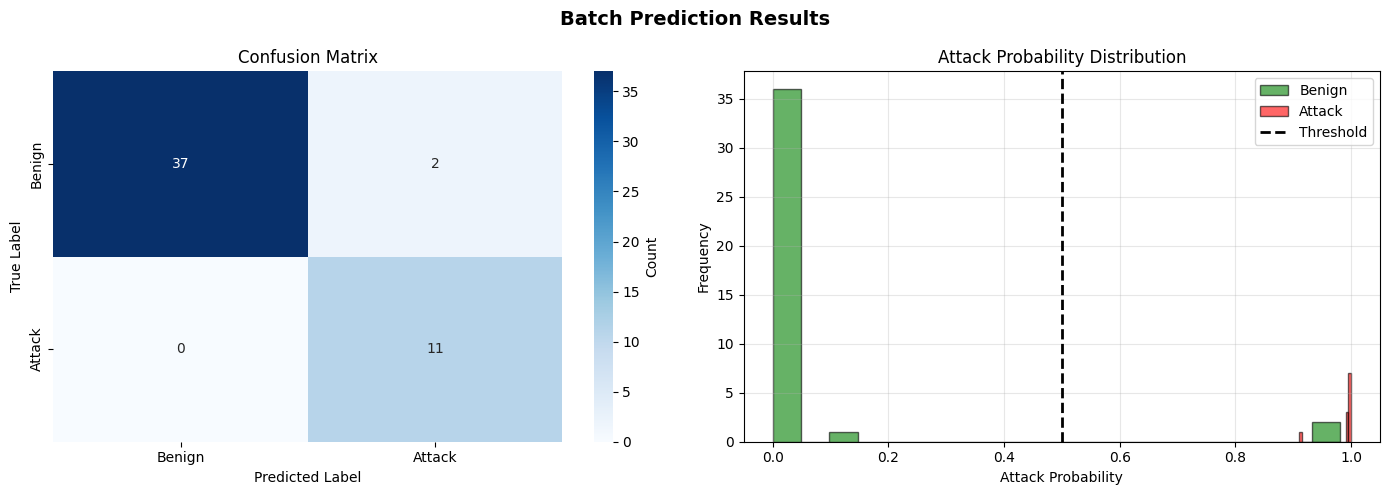


Batch prediction complete!


In [ ]:
# ==================== CELL 4: DEMO - BATCH PREDICTIONS ====================
"""
Cell 4: Batch prediction demo with visualization
"""

print("\n" + "="*70)
print("DEMO 2: BATCH PREDICTION")
print("="*70)

# Generate 50 mixed flows (30% attacks)
n_flows = 50
attack_ratio = 0.35

print(f"\nGenerating {n_flows} mixed network flows...")
print(f"   Attack ratio: {attack_ratio:.0%}")
print("-" * 70)

flows = simulator.generate_mixed_traffic(n_flows=n_flows, attack_ratio=attack_ratio)

# Make predictions
print("Making predictions...")
results = detector.predict_batch(flows)

# Calculate metrics
correct = sum((results['Prediction'] == 1) & (results['True_Label'] == 'DoS Attack') |
             (results['Prediction'] == 0) & (results['True_Label'] == 'Benign'))
accuracy = correct / len(results) * 100

# Confusion matrix values
tp = sum((results['Prediction'] == 1) & (results['True_Label'] == 'DoS Attack'))
fp = sum((results['Prediction'] == 1) & (results['True_Label'] == 'Benign'))
tn = sum((results['Prediction'] == 0) & (results['True_Label'] == 'Benign'))
fn = sum((results['Prediction'] == 0) & (results['True_Label'] == 'DoS Attack'))

# Display summary
print("\n" + "="*70)
print("BATCH PREDICTION RESULTS")
print("="*70)
print(f"Total Flows: {len(results)}")
print(f"Predicted Attacks: {(results['Prediction'] == 1).sum()}")
print(f"Predicted Benign: {(results['Prediction'] == 0).sum()}")
print(f"Detection Accuracy: {accuracy:.2f}%")
print(f"Average Confidence: {results['Confidence'].mean():.2%}")

print("\n" + "="*70)
print("CONFUSION MATRIX")
print("="*70)
print(f"True Positives (Attacks detected):  {tp}")
print(f"True Negatives (Benign detected):   {tn}")
print(f"False Positives (False alarms):     {fp}")
print(f"False Negatives (Missed attacks):   {fn}")

# Show sample results
print("\n" + "="*70)
print("SAMPLE PREDICTIONS (First 10 flows)")
print("="*70)
display_cols = ['Flow_ID', 'True_Label', 'Prediction_Label', 'Attack_Probability', 'Confidence']
print(results[display_cols].head(10).to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Batch Prediction Results', fontsize=14, fontweight='bold')

# Plot 1: Confusion Matrix
cm = np.array([[tn, fp], [fn, tp]])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Attack'],
            yticklabels=['Benign', 'Attack'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Plot 2: Attack Probability Distribution
axes[1].hist(results[results['True_Label'] == 'Benign']['Attack_Probability'],
            bins=20, alpha=0.6, label='Benign', color='green', edgecolor='black')
axes[1].hist(results[results['True_Label'] == 'DoS Attack']['Attack_Probability'],
            bins=20, alpha=0.6, label='Attack', color='red', edgecolor='black')
axes[1].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[1].set_xlabel('Attack Probability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Attack Probability Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Batch prediction complete!")
print("="*70)


DEMO 3: LIVE TRAFFIC SIMULATION

Simulation Parameters:
   Duration: 30 seconds
   Flow rate: 2.0 flows/second
   Attack probability: 35%

Starting live simulation...
   (Watch the real-time statistics below)
----------------------------------------------------------------------
Flow  56 |  30.0s | BENIGN          | Conf: ████████████████████ 100.0% | Attack Rate:  35.7%
----------------------------------------------------------------------

SIMULATION COMPLETE - FINAL STATISTICS

Traffic Statistics:
   Total Flows Processed: 68
   Attacks Detected: 26
   Benign Flows: 42
   Attack Rate: 0.4%

Performance Metrics:
   Total Duration: 30.51 seconds
   Average Flow Rate: 1.84 flows/second
   Processing Speed: 544.75 ms/flow

Generating visualization dashboard...


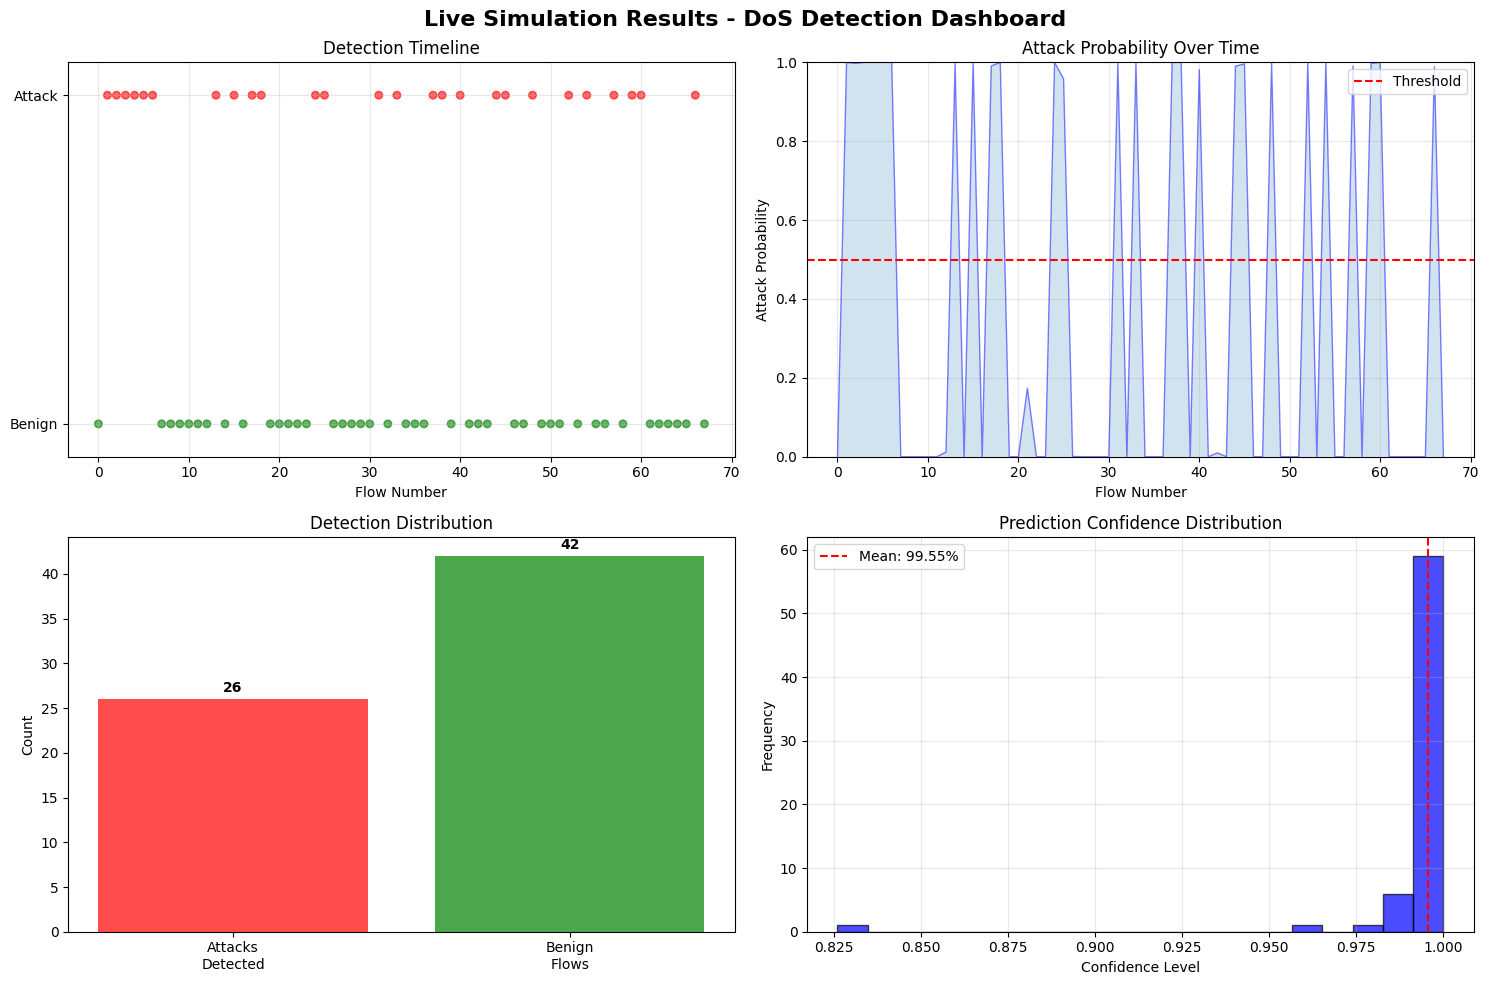


Live simulation and visualization complete!


In [ ]:
# ==================== CELL 5: DEMO - LIVE SIMULATION ====================
"""
Cell 5: Live traffic simulation with real-time detection
"""

print("\n" + "="*70)
print("DEMO 3: LIVE TRAFFIC SIMULATION")
print("="*70)

# Simulation parameters
duration = 30  # seconds
flows_per_second = 2.0
attack_probability = 0.35

print(f"\nSimulation Parameters:")
print(f"   Duration: {duration} seconds")
print(f"   Flow rate: {flows_per_second} flows/second")
print(f"   Attack probability: {attack_probability:.0%}")
print("\nStarting live simulation...")
print("   (Watch the real-time statistics below)")
print("-" * 70)

start_time = time.time()
flow_count = 0
attack_count = 0
benign_count = 0

try:
    while (time.time() - start_time) < duration:
        # Generate flow (benign or attack)
        if random.random() < attack_probability:
            flow = simulator.generate_dos_flow()
            true_label = "DoS Attack"
        else:
            flow = simulator.generate_benign_flow()
            true_label = "Benign"

        # Make prediction
        result = detector.predict_single_flow(flow)
        flow_count += 1

        # Update counts
        if result['prediction_label'] == 1:
            attack_count += 1
            status = "ATTACK"
            status_icon = ""
        else:
            benign_count += 1
            status = "BENIGN"
            status_icon = ""

        # Calculate metrics
        elapsed = time.time() - start_time
        attack_rate = (attack_count / flow_count * 100) if flow_count > 0 else 0

        # Create confidence bar
        conf_level = int(result['confidence'] * 20)
        confidence_bar = "█" * conf_level + "░" * (20 - conf_level)

        # Real-time display
        print(f"\r{status_icon}Flow {flow_count:3d} | "
              f"{elapsed:5.1f}s | {status:15s} | "
              f"Conf: {confidence_bar} {result['confidence']:.1%} | "
              f"Attack Rate: {attack_rate:5.1f}%",
              end='', flush=True)

        # Sleep to control flow rate
        time.sleep(1.0 / flows_per_second)

except KeyboardInterrupt:
    print("\n\nSimulation stopped by user.")

# Final statistics
print("\n" + "-" * 70)
print("\n" + "="*70)
print("SIMULATION COMPLETE - FINAL STATISTICS")
print("="*70)

stats = detector.get_statistics()
elapsed_time = time.time() - start_time

print(f"\nTraffic Statistics:")
print(f"   Total Flows Processed: {stats['total_flows']}")
print(f"   Attacks Detected: {stats['attacks_detected']}")
print(f"   Benign Flows: {stats['benign_flows']}")
print(f"   Attack Rate: {stats['attack_rate']:.1f}%")

print(f"\nPerformance Metrics:")
print(f"   Total Duration: {elapsed_time:.2f} seconds")
print(f"   Average Flow Rate: {flow_count / elapsed_time:.2f} flows/second")
print(f"   Processing Speed: {elapsed_time / flow_count * 1000:.2f} ms/flow")

# Visualization
print("\nGenerating visualization dashboard...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Live Simulation Results - DoS Detection Dashboard',
             fontsize=16, fontweight='bold')

history = list(detector.detection_history)
predictions = [h['prediction_label'] for h in history]
attack_probs = [h['attack_probability'] for h in history]
confidences = [h['confidence'] for h in history]

# Plot 1: Detection Timeline
colors = ['green' if p == 0 else 'red' for p in predictions]
axes[0, 0].scatter(range(len(predictions)), predictions, c=colors, alpha=0.6, s=30)
axes[0, 0].set_ylim(-0.1, 1.1)
axes[0, 0].set_yticks([0, 1])
axes[0, 0].set_yticklabels(['Benign', 'Attack'])
axes[0, 0].set_xlabel('Flow Number')
axes[0, 0].set_title('Detection Timeline')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Attack Probability Trend
axes[0, 1].plot(attack_probs, 'b-', alpha=0.5, linewidth=1)
axes[0, 1].axhline(y=0.5, color='r', linestyle='--', label='Threshold')
axes[0, 1].fill_between(range(len(attack_probs)), 0, attack_probs, alpha=0.2)
axes[0, 1].set_ylim(0, 1)
axes[0, 1].set_xlabel('Flow Number')
axes[0, 1].set_ylabel('Attack Probability')
axes[0, 1].set_title('Attack Probability Over Time')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Detection Distribution
categories = ['Attacks\nDetected', 'Benign\nFlows']
values = [stats['attacks_detected'], stats['benign_flows']]
axes[1, 0].bar(categories, values, color=['red', 'green'], alpha=0.7)
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Detection Distribution')
for i, v in enumerate(values):
    axes[1, 0].text(i, v + max(values)*0.02, str(v), ha='center', fontweight='bold')

# Plot 4: Confidence Distribution
axes[1, 1].hist(confidences, bins=20, color='blue', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=np.mean(confidences), color='r', linestyle='--',
                   label=f'Mean: {np.mean(confidences):.2%}')
axes[1, 1].set_xlabel('Confidence Level')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Prediction Confidence Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Live simulation and visualization complete!")
print("="*70)

## Efficient Restart: Load Data, Scaler, and Model

This section provides a consolidated script to quickly get your environment ready after a Colab runtime restart. It will re-load all necessary configurations, preprocess your data, and load your saved `scaler` and `RandomForestClassifier` model, avoiding the need to re-train the model from scratch.

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import zipfile
from typing import List, Tuple, Optional
import os
from glob import glob

# ML libraries (needed for StandardScaler and RandomForestClassifier)
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score
)
import joblib
import json

# Mount Google Drive (if not already mounted)
from google.colab import drive
if not os.path.exists("/content/drive"):
    drive.mount("/content/drive", force_remount=True)

# Re-define BASE_DIR and MODEL_BASE_DIR (from cell _IeZ9qzRBooO)
BASE_DIR = "/content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation"
DATA_GLOB = str(Path(BASE_DIR) / "*.csv")
MODEL_BASE_DIR = os.path.join(BASE_DIR, "saved_models")
os.makedirs(MODEL_BASE_DIR, exist_ok=True)

# Re-define Model Persistence Utility Functions (from cell x2DbkU9GNgZ)
# (Copying here to make this block self-contained for restart)
def save_model(model, model_name: str, model_type: str = "model"):
    os.makedirs(MODEL_BASE_DIR, exist_ok=True)
    filepath = os.path.join(MODEL_BASE_DIR, f"{model_name}.joblib")
    try:
        joblib.dump(model, filepath)
        print(f"{model_type.title()} '{model_name}' saved to:\n  {filepath}")
        return filepath
    except Exception as e:
        print(f"Error saving {model_type} '{model_name}': {e}")
        return None

def load_model(model_name: str, model_type: str = "model"):
    filepath = os.path.join(MODEL_BASE_DIR, f"{model_name}.joblib")
    if not os.path.exists(filepath):
        print(f" {model_type.title()} file '{model_name}.joblib' not found at:\n  {filepath}")
        return None
    try:
        loaded_model = joblib.load(filepath)
        print(f" {model_type.title()} '{model_name}' loaded from:\n  {filepath}")
        return loaded_model
    except Exception as e:
        print(f" Error loading {model_type} '{model_name}': {e}")
        return None

# Re-define CONFIGURATION & FEATURE DEFINITIONS (from cell BniBuuNwP3ja)
TARGET_FILES = [
    "02-15-2018.csv", "02-16-2018.csv", "02-21-2018.csv", "03-01-2018.csv",
]
MAX_ROWS_PER_FILE: int | None = None # Set to None for full dataset
ATTACK_KEYWORDS = [
    "DoS", "DDoS", "Hulk", "GoldenEye", "Slowloris", "HOIC", "LOIC", "LOIC-UDP"
]
LABEL_COL = "Label"
CANDIDATE_FEATURES = [
    "Flow Duration", "Tot Fwd Pkts", "Tot Bwd Pkts", "TotLen Fwd Pkts",
    "TotLen Bwd Pkts", "Fwd Pkt Len Mean", "Bwd Pkt Len Mean",
    "Fwd Pkt Len Std", "Bwd Pkt Len Std", "Flow Byts/s", "Flow Pkts/s",
    "Fwd IAT Mean", "Bwd IAT Mean", "Flow IAT Mean", "Fwd IAT Std",
    "Bwd IAT Std", "Pkt Len Mean", "Pkt Len Std", "Pkt Len Var",
    "Down/Up Ratio", "Bwd Pkts/b Avg", "Fwd Pkts/b Avg",
    "Bwd Seg Size Avg", "Fwd Seg Size Avg", "Subflow Fwd Pkts",
    "Subflow Bwd Pkts", "Subflow Fwd Byts", "Subflow Bwd Byts",
    "Fwd Act Data Pkts", "Idle Mean", "Idle Std", "Idle Max", "Idle Min",
]
OPTIONAL_FEATURES = [
    "SYN Flag Cnt", "ACK Flag Cnt", "PSH Flag Cnt", "RST Flag Cnt", "URG Flag Cnt"
]
UNIQUE_VALUE_COLS = [
    "Flow ID", "Src IP", "Dst IP", "Src Port", "Dst Port", "Timestamp",
    "TimeStamp", "Source IP", "Destination IP", "Source Port",
    "Destination Port", "__source_file",
]
LEAKY_COLS = [
    "Label", "y", "Timestamp", "TimeStamp", "__source_file",
    "Flow ID", "Src IP", "Dst IP", "Src Port",
]
RISKY_COLS = ["Dst Port", "Protocol"]
RATE_COLS = ["Flow Byts/s", "Flow Pkts/s"]
NON_FEATURE_COLS = set(UNIQUE_VALUE_COLS + LEAKY_COLS)

print("All configurations and utility functions loaded.")

# --- Step 2: Re-define Data Loading & Labeling Functions (from cell yVFr92NuqolW) ---
# (Copying here to make this block self-contained for restart)
def _read_csv(fpath: Path, max_rows: int | None) -> pd.DataFrame:
    if str(fpath).endswith(".zip"):
        with zipfile.ZipFile(fpath, "r") as z:
            inner_csvs = [n for n in z.namelist() if n.lower().endswith(".csv")]
            if not inner_csvs:
                raise ValueError(f"No CSV found inside {fpath.name}")
            inner = inner_csvs[0]
            with z.open(inner) as fh:
                return pd.read_csv(fh, low_memory=False, nrows=max_rows)
    else:
        return pd.read_csv(fpath, low_memory=False, nrows=max_rows)

def load_cic_csvs(glob_pattern: str = DATA_GLOB, max_rows_per_file: int | None = MAX_ROWS_PER_FILE, target_files: List[str] = None) -> pd.DataFrame:
    all_files = sorted(Path(glob_pattern).parent.glob(Path(glob_pattern).name))
    if not all_files: raise FileNotFoundError(f"No files matched pattern: {glob_pattern}")
    files_to_load = [f for f in all_files if f.name in target_files] if target_files else all_files
    if not files_to_load: raise FileNotFoundError(f"None of the target files {target_files} found in {Path(glob_pattern).parent}")
    print(f"\n Loading {len(files_to_load)} target files...")
    dfs: List[pd.DataFrame] = []
    for i, f in enumerate(files_to_load, 1):
        try:
            print(f"  [{i}/{len(files_to_load)}] Loading: {f.name:35s} ... ", end="")
            df = _read_csv(f, max_rows_per_file)
            df["__source_file"] = f.name
            dfs.append(df)
            print(f"{len(df):,} rows")
        except Exception as e: print(f"Error: {e}"); continue
    if not dfs: raise RuntimeError("No data could be loaded (all files failed).")
    combined_df = pd.concat(dfs, ignore_index=True)
    print(f"\n DATA LOADING COMPLETE: {len(combined_df):,} rows, {len(combined_df.columns)} cols")
    return combined_df

def label_binary_dos(df: pd.DataFrame, label_col: str = LABEL_COL, attack_keywords: List[str] = None, verbose: bool = True) -> pd.DataFrame:
    if attack_keywords is None: attack_keywords = ATTACK_KEYWORDS
    if label_col not in df.columns:
        matches = [c for c in df.columns if c.lower() == label_col.lower()]
        if matches: df = df.rename(columns={matches[0]: label_col})
        else: raise KeyError(f"Column '{label_col}' not found.")
    labels = df[label_col].astype(str).str.strip()
    is_dos_attack = np.zeros(len(df), dtype=bool)
    for kw in attack_keywords: is_dos_attack |= labels.str.contains(kw, case=False, na=False)
    is_benign = labels.str.contains("BENIGN", case=False, na=False)
    keep_mask = is_benign | is_dos_attack
    df = df.loc[keep_mask].copy()
    df["y"] = (is_dos_attack[keep_mask] & ~is_benign[keep_mask]).astype(int)
    return df

print("Data loading and labeling functions defined.")

# --- Step 3: Re-load Raw Data, Deduplicate, Label (from cells Z2LnjgFbRJjg, os3kzR_TTba4, 2SFfAZHYUllg) ---
print("\nLoading and preprocessing data...")
df_raw = load_cic_csvs(glob_pattern=DATA_GLOB, max_rows_per_file=MAX_ROWS_PER_FILE, target_files=TARGET_FILES)

def remove_duplicates_correctly(df: pd.DataFrame, label_col: str = LABEL_COL) -> pd.DataFrame:
    cols_for_dup_check = [col for col in df.columns if col not in UNIQUE_VALUE_COLS and col != label_col]
    df_clean = df.drop_duplicates(subset=cols_for_dup_check, keep='first')
    return df_clean

df_dedup = remove_duplicates_correctly(df_raw, LABEL_COL)
df_labeled = label_binary_dos(df=df_dedup, label_col=LABEL_COL, attack_keywords=ATTACK_KEYWORDS)
df = df_labeled.copy() # Ensure df is updated
print(f"Data loaded, deduplicated, and labeled. Shape: {df.shape}")

# --- Step 4: Re-perform Feature Preparation (from cell zH3zUnjWH1s6) ---
available_features = [f for f in CANDIDATE_FEATURES if f in df.columns]
optional_available = [f for f in OPTIONAL_FEATURES if f in df.columns]
FINAL_FEATURES = available_features + optional_available

keep_cols = FINAL_FEATURES + ['y', 'Label']
if 'Timestamp' in df.columns: keep_cols.append('Timestamp')
df_features = df[keep_cols].copy()

for col in FINAL_FEATURES:
    if col in df_features.columns: df_features[col] = pd.to_numeric(df_features[col], errors='coerce')
rate_cols = ["Flow Byts/s", "Flow Pkts/s"]
for col in rate_cols:
    if col in df_features.columns: df_features[col] = df_features[col].replace([np.inf, -np.inf], np.nan)
df_features[FINAL_FEATURES] = df_features[FINAL_FEATURES].fillna(0)
if 'Timestamp' in df_features.columns: df_features = df_features.drop(columns=['Timestamp'])
df = df_features.copy() # Update df for next step
print(f"Features prepared. Final dataset shape: {df.shape}")

# --- Step 5: Re-split Data (from cell fBzeoKOjlnkz) ---
X = df[FINAL_FEATURES].values
y = df['y'].values
TRAIN_SIZE = 0.70; VAL_SIZE = 0.15; TEST_SIZE = 0.15; RANDOM_STATE = 42
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(VAL_SIZE + TEST_SIZE), random_state=RANDOM_STATE, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(TEST_SIZE / (VAL_SIZE + TEST_SIZE)), random_state=RANDOM_STATE, stratify=y_temp)
print(f"Data split into Train ({len(X_train)}), Val ({len(X_val)}), Test ({len(X_test)}) sets.")

# --- Step 6: Load Saved Scaler and Scale Data ---
print("\nLoading and applying scaler...")
scaler = load_model("dos_feature_scaler", "scaler")
if scaler:
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    print("Scaler loaded and applied to all datasets.")
else:
    print("Error: Scaler not found. You might need to re-run the scaling cell if it wasn't saved.")
    # Fallback if scaler isn't loaded - you might need to re-initialize and fit if not saved
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

# --- Step 7: Load Saved Random Forest Model ---
print("\nLoading Random Forest model...")
rf_model = load_model("dos_random_forest", "Random Forest")
if rf_model:
    print("Random Forest model loaded.")
    # Re-evaluate to get test_metrics_rf and predictions if needed for downstream cells
    y_test_pred_rf = rf_model.predict(X_test_scaled)
    y_test_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

    # Define a simple evaluate_model for this context if it was not available globally
    def evaluate_model(y_true, y_pred, y_proba, set_name="Test"):
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
        pr_auc = average_precision_score(y_true, y_proba) if y_proba is not None else None
        cm = confusion_matrix(y_true, y_pred)
        return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc_auc, 'pr_auc': pr_auc, 'confusion_matrix': cm}

    # Re-calculate test_metrics_rf
    test_metrics_rf = evaluate_model(y_test, y_test_pred_rf, y_test_proba_rf, "Test")
    print(f"Test metrics for Random Forest re-calculated: Accuracy {test_metrics_rf['accuracy']:.4f}")

else:
    print("Error: Random Forest model not found. You might need to re-run the training cell.")

# --- Step 8: Load Saved Logistic Regression Model (for comparison if needed) ---
print("\nLoading Logistic Regression model (for comparison)...")
lr_model = load_model("dos_logistic_regression", "Logistic Regression")
if lr_model:
    print("Logistic Regression model loaded.")
    # Also re-evaluate LR test metrics if needed for comparison
    y_test_pred = lr_model.predict(X_test_scaled)
    y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
    test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, "Test")
    print(f"Test metrics for Logistic Regression re-calculated: Accuracy {test_metrics['accuracy']:.4f}")
else:
    print("Error: Logistic Regression model not found.")

# --- Step 9: Load Saved XGBoost components ---
print("\nLoading XGBoost calibrator and threshold...")
# Load calibrator
iso = load_model("xgboost_calibrator", "calibrator")
if iso:
    print("XGBoost calibrator loaded.")
else:
    print("Error: XGBoost calibrator not found. You might need to re-run the XGBoost training cell.")

# Load threshold from config
config_path = os.path.join(MODEL_BASE_DIR, "xgboost_config.json")
thr_star = None
if os.path.exists(config_path):
    with open(config_path, 'r') as f:
        xgb_config = json.load(f)
    thr_star = xgb_config.get('threshold')
    if thr_star is not None:
        print(f"XGBoost optimized threshold loaded: {thr_star:.4f}")
    else:
        print("Error: 'threshold' not found in xgboost_config.json.")
else:
    print("Error: xgboost_config.json not found. You might need to re-run the XGBoost training cell.")


print(f"\n{'='*70}")
print("ENVIRONMENT READY!")
print(f"{'='*70}")
print("You can now proceed with inference, visualization, or further analysis.")
print("The following variables are available:")
print(" - df, X_train, y_train, X_val, y_val, X_test, y_test")
print(" - X_train_scaled, X_val_scaled, X_test_scaled")
print(" - FINAL_FEATURES")
print(" - scaler (loaded StandardScaler object)")
print(" - rf_model (loaded RandomForestClassifier)")
print(" - test_metrics_rf (metrics for RF model)")
print(" - lr_model (loaded LogisticRegression model)")
print(" - test_metrics (metrics for LR model)")
print(" - iso (loaded IsotonicRegression object for XGBoost calibration)")
print(" - thr_star (loaded optimized threshold for XGBoost)")
print(f"{'='*70}\n")

Mounted at /content/drive
All configurations and utility functions loaded.
Data loading and labeling functions defined.

Loading and preprocessing data...

 Loading 4 target files...
  [1/4] Loading: 02-15-2018.csv                      ... 1,048,575 rows
  [2/4] Loading: 02-16-2018.csv                      ... 1,048,575 rows
  [3/4] Loading: 02-21-2018.csv                      ... 1,048,575 rows
  [4/4] Loading: 03-01-2018.csv                      ... 331,125 rows

 DATA LOADING COMPLETE: 3,476,850 rows, 81 cols
Data loaded, deduplicated, and labeled. Shape: (2133965, 82)
Features prepared. Final dataset shape: (2133965, 40)
Data split into Train (1493775), Val (320095), Test (320095) sets.

Loading and applying scaler...
 Scaler 'dos_feature_scaler' loaded from:
  /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation/saved_models/dos_feature_scaler.joblib
Scaler loaded and applied to all datasets.

Loading Random Forest model...
 Random Forest 'dos_random_forest' loaded f

In [ ]:
# ==================== TEST SYNTHETIC FLOWS ====================

print("="*70)
print("TESTING SYNTHETIC FLOWS")
print("="*70)

# Generate synthetic benign flow
def create_synthetic_benign():
    flow = {
        'Flow Duration': np.random.randint(1000, 50000),
        'Total Fwd Packets': np.random.randint(5, 50),
        'Total Backward Packets': np.random.randint(5, 50),
        'Flow Bytes/s': np.random.uniform(1000, 100000),
        'Flow Packets/s': np.random.uniform(10, 500),
    }
    # Fill remaining features with small random values
    for i in range(len(FINAL_FEATURES) - len(flow)):
        flow[f'Feature_{i}'] = np.random.uniform(0, 10)

    # Make sure we have exactly the right features
    flow_df = pd.DataFrame([flow])
    # Reindex to match FINAL_FEATURES
    for feat in FINAL_FEATURES:
        if feat not in flow_df.columns:
            flow_df[feat] = 0

    return flow_df[FINAL_FEATURES]

# Generate synthetic attack flow
def create_synthetic_attack():
    flow = {
        'Flow Duration': np.random.randint(100, 5000),
        'Total Fwd Packets': np.random.randint(100, 1000),
        'Total Backward Packets': np.random.randint(0, 10),
        'Flow Bytes/s': np.random.uniform(100000, 1000000),
        'Flow Packets/s': np.random.uniform(1000, 10000),
    }
    # Fill remaining with higher values
    for i in range(len(FINAL_FEATURES) - len(flow)):
        flow[f'Feature_{i}'] = np.random.uniform(0, 50)

    flow_df = pd.DataFrame([flow])
    for feat in FINAL_FEATURES:
        if feat not in flow_df.columns:
            flow_df[feat] = 0

    return flow_df[FINAL_FEATURES]

# Test synthetic benign
print("\n1. Testing Synthetic BENIGN flow:")
synthetic_benign = create_synthetic_benign()
synthetic_benign_scaled = scaler.transform(synthetic_benign)
pred_benign = rf_model.predict(synthetic_benign_scaled)
prob_benign = rf_model.predict_proba(synthetic_benign_scaled)

print(f"   Prediction: {'Attack' if pred_benign[0] == 1 else 'Benign'}")
print(f"   Confidence: {prob_benign[0][pred_benign[0]]*100:.2f}%")
print(f"   Result: {'❌ WRONG' if pred_benign[0] == 1 else '✅ CORRECT'}")

# Test synthetic attack
print("\n2. Testing Synthetic ATTACK flow:")
synthetic_attack = create_synthetic_attack()
synthetic_attack_scaled = scaler.transform(synthetic_attack)
pred_attack = rf_model.predict(synthetic_attack_scaled)
prob_attack = rf_model.predict_proba(synthetic_attack_scaled)

print(f"   Prediction: {'Attack' if pred_attack[0] == 1 else 'Benign'}")
print(f"   Confidence: {prob_attack[0][pred_attack[0]]*100:.2f}%")
print(f"   Result: {'✅ CORRECT' if pred_attack[0] == 1 else '❌ WRONG'}")

# Test with real sample for comparison
print("\n3. Testing REAL BENIGN flow (for comparison):")
real_benign = benign_samples.iloc[0:1]
real_benign_scaled = scaler.transform(real_benign)
pred_real_benign = rf_model.predict(real_benign_scaled)
prob_real_benign = rf_model.predict_proba(real_benign_scaled)

print(f"   Prediction: {'Attack' if pred_real_benign[0] == 1 else 'Benign'}")
print(f"   Confidence: {prob_real_benign[0][pred_real_benign[0]]*100:.2f}%")
print(f"   Result: {'❌ WRONG' if pred_real_benign[0] == 1 else '✅ CORRECT'}")

print("\n4. Testing REAL ATTACK flow (for comparison):")
real_attack = attack_samples.iloc[0:1]
real_attack_scaled = scaler.transform(real_attack)
pred_real_attack = rf_model.predict(real_attack_scaled)
prob_real_attack = rf_model.predict_proba(real_attack_scaled)

print(f"   Prediction: {'Attack' if pred_real_attack[0] == 1 else 'Benign'}")
print(f"   Confidence: {prob_real_attack[0][pred_real_attack[0]]*100:.2f}%")
print(f"   Result: {'✅ CORRECT' if pred_real_attack[0] == 1 else '❌ WRONG'}")

print("\n" + "="*70)
print("CONCLUSION:")
print("If synthetic flows predict incorrectly, use REAL test samples instead!")
print("="*70)

TESTING SYNTHETIC FLOWS

1. Testing Synthetic BENIGN flow:
   Prediction: Benign
   Confidence: 90.13%
   Result: ✅ CORRECT

2. Testing Synthetic ATTACK flow:
   Prediction: Benign
   Confidence: 90.13%
   Result: ❌ WRONG

3. Testing REAL BENIGN flow (for comparison):
   Prediction: Benign
   Confidence: 100.00%
   Result: ✅ CORRECT

4. Testing REAL ATTACK flow (for comparison):
   Prediction: Attack
   Confidence: 98.92%
   Result: ✅ CORRECT

CONCLUSION:
If synthetic flows predict incorrectly, use REAL test samples instead!


### APIs Used and Their Purpose:

*   **Google Colab APIs (e.g., `google.colab.drive`, `google.colab.userdata`)**: These are used for interacting with the Colab environment, specifically for mounting Google Drive to access datasets and potentially for securely storing and accessing credentials (though `userdata` for API keys isn't explicitly used for the listed APIs, it's present in the initial setup cells).
*   **`joblib`**: This library is used for saving and loading Python objects, particularly machine learning models. It's used here to persist the trained Random Forest and XGBoost models to Google Drive so they can be reused later without retraining.
*   **`os`**: This module provides a way to interact with the operating system, such as creating directories (`os.makedirs`) and checking for file existence (`os.path.exists`). It's used for managing file paths and directories for saving/loading models.
*   **`pathlib`**: This module offers an object-oriented way to handle filesystem paths. It's used for constructing file paths in a more readable and portable way.
*   **`pandas`**: A fundamental data manipulation and analysis library. Extensively used for loading, cleaning, transforming, and analyzing the dataset, including handling CSV files, creating DataFrames, selecting columns, handling missing values, and converting data types.
*   **`numpy`**: A core library for numerical computing in Python. Used for numerical operations, array manipulation, and handling special values like infinity and NaN.
*   **`sklearn.metrics`**: Part of the scikit-learn library, this module provides various functions for evaluating the performance of machine learning models, such as `precision_recall_curve`, `classification_report`, `confusion_matrix`, `roc_auc_score`, and `average_precision_score`.
*   **`sklearn.model_selection`**: Also part of scikit-learn, used for splitting datasets. `StratifiedShuffleSplit` and `GroupShuffleSplit` are imported, although a custom time-based split is implemented. `GridSearchCV` is used for hyperparameter tuning (though commented out in the RF section).
*   **`zipfile`**: Used to work with ZIP archives, specifically for reading CSV files compressed within `.zip` files.
*   **`typing`**: Provides type hints for better code readability and maintainability.
*   **`matplotlib.pyplot`**: A widely used plotting library for creating visualizations like the class balance bar and pie charts, as well as ROC and Precision-Recall curves and confusion matrix heatmaps.
*   **`seaborn`**: A statistical data visualization library based on matplotlib, used here specifically for creating the confusion matrix heatmap with enhanced aesthetics.
*   **`cuml.ensemble.RandomForestClassifier`**: Part of the RAPIDS cuML library, this is a GPU-accelerated implementation of the Random Forest classifier, used for training the Random Forest model on the GPU.
*   **`cudf`**: Part of the RAPIDS suite, providing a GPU-accelerated DataFrame library. Used to convert pandas DataFrames to cuDF DataFrames for use with cuML.
*   **`cupy`**: Part of the RAPIDS suite, providing a GPU-accelerated NumPy-compatible array library. Used for array operations on the GPU in conjunction with cuML.
*   **`xgboost`**: A popular gradient boosting library. Used for training the XGBoost model, leveraging GPU acceleration (`device='cuda'`). It also has its own DMatrix format for optimized data handling.
*   **`sklearn.isotonic.IsotonicRegression`**: Part of scikit-learn, used for calibrating the model's predicted probabilities to improve their reliability.
*   **`pyngrok`**: A Python wrapper for ngrok, used to create a public URL tunnel to the locally running Flask application, making it accessible from the internet.
*   **`flask`**: A lightweight web server gateway interface web application framework. Used to create a simple web API to serve the trained model for inference.
*   **`requests`**: A popular library for making HTTP requests. Used to test the Flask API endpoint by sending a POST request with sample data.

In [ ]:
# Save test samples for UI to use
import joblib

# Prepare test samples
X_test_df = pd.DataFrame(X_test, columns=FINAL_FEATURES)
y_test_series = pd.Series(y_test)

benign_samples = X_test_df[y_test_series == 0].sample(min(1000, len(X_test_df[y_test_series == 0])))
attack_samples = X_test_df[y_test_series == 1].sample(min(1000, len(X_test_df[y_test_series == 1])))

test_samples = {
    'benign': benign_samples,
    'attack': attack_samples,
    'feature_names': FINAL_FEATURES
}

# Save it
save_path = f"{MODEL_BASE_DIR}/test_samples.joblib"
joblib.dump(test_samples, save_path)
print(f"✓ Saved test samples to {save_path}")

✓ Saved test samples to /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation/saved_models/test_samples.joblib


In [7]:
#!pip install streamlit pyngrok -q
# ========== RUN THIS ONCE PER SESSION ==========

# 1. Install requirements
!pip install streamlit pyngrok -q
import os
from glob import glob
# Mount Google Drive (if not already mounted)
from google.colab import drive
if not os.path.exists("/content/drive"):
  drive.mount("/content/drive", force_remount=True)

# 2. Install cloudflared (if not present)
import os
if os.system('which cloudflared > /dev/null 2>&1') != 0:
    !wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
    !dpkg -i cloudflared-linux-amd64.deb

print("✓ Setup complete!")

Mounted at /content/drive
✓ Setup complete!


In [8]:
# Kill everything
!pkill -f streamlit
!pkill -f localtunnel
!pkill -f lt

import time
time.sleep(3)
print("✓ Cleaned up old processes")

✓ Cleaned up old processes


In [9]:
# Start streamlit in background
!nohup streamlit run /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation/IDS_UI_2.0.py --server.port 8501 > /tmp/streamlit.log 2>&1 &

import time
time.sleep(10)

# Check the streamlit log for errors
!tail -50 /tmp/streamlit.log

# Check if it's running
!curl -s http://localhost:8501 > /dev/null && echo "✓ Streamlit is running!" || echo "✗ Streamlit failed to start"

# Create tunnel
!cloudflared tunnel --url http://localhost:8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.229.187.213:8501

✓ Streamlit is running!
2025-11-15T17:29:27Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-11-15T17:29:27Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-11-15T17:29:31Z INF +--------------------------------------------------------------------------------------------+


In [5]:
# Get the Colab proxy URL
from google.colab.output import eval_js
url = eval_js("google.colab.kernel.proxyPort(8501)")
print(f"\n🌐 Your UI is at: {url}")


🌐 Your UI is at: https://8501-gpu-t4-hm-jih4wdrcv8f6-c.asia-east1-2.prod.colab.dev


Usage: streamlit run [OPTIONS] [TARGET] [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: /content/drive/Shareddrives/CMPE279/CMPE279-IDSandAttackMitigation/IDS_UI_2.0.py
